# Wat is het verband tussen vertragingen en het weer?

Dit notebook is gemaakt voor het AI4 semester van Fontys ICT, als onderdeel van een eigen uitdaging.

Het is geschreven door mij, **Anne Koppers**.

In dit notebook ga ik proberen te onderzoeken of het weer invloed heeft op vertragingen in het openbaar treinverkeer.

Met behulp van deze datasets hoop ik te kunnen ontdekken of en waar er een sterke correlatie is.



In mijn uitdaging ga ik gebruik maken van **Python Pandas**, een bibliotheek om datasets in te laden. Daarnaast ga ik ook gebruik maken van **Plotly** om de data op een visueel aantrekkelijke manier weer te geven, en **Scikit-learn (sklearn)** voor de machine learning algoritmes.

Afhankelijkheden voor de uitdaging:

In [1]:
# dependances
import os
import numpy as np
# import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
# from geopy.exc import GeocoderTimedOut
# from geopy.geocoders import Nominatim
# from geopy.distance import geodesic
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

import warnings
# warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

datafolder = 'data/'

max_data = datetime(2023, 4, 1, 0, 0, 0)
calculate_large_data = False

# 📦 Data opzet

Ik ben op zoek gegaan naar datasets die relevant kunnen zijn voor mijn opdracht. 

Dit zijn de datasets die ik heb gekozen en waarom ik deze heb gekozen:
- [rijden de treinen. Treinarchief](https://www.rijdendetreinen.nl/open-data/treinarchief) \
deze dataset heeft alle data van het trein verkeer. waaronder de verwachte aankomst tijd en hoeveel minuten hij te laat was.
- [rijden de treinen. treinstoringen](https://www.rijdendetreinen.nl/open-data/treinstoringen) \
deze dataset heeft informatie over wat voor storingen er vermeld werden. deze will ik gebruiken om te controleren wat mijn vindingen zijn aan het einde.
- [rijden de treinen. treinstations](https://www.rijdendetreinen.nl/open-data/treinstations) \
Deze dataset bevat de coördinaten van de trein stations van de dataset.   \
de datasets van Rijden de treinen woord gebruikt door nieuws programmas and kranten zoals AD en Volkskrant. En heeft data die ik nodig heb om mijn berekeningen te doen Dit maakt ze betrouwbaar en geschrikt voor wat ik will berijken.

- [KNMI weerstations Uurwaarnemingen](https://www.daggegevens.knmi.nl/klimatologie/uurgegevens) \
Dit is een dataset van de overheid. dit zoorgt ervoor dat het betrouwbaar genoeg is om er van overtuigt the zijn dat het betrouwbaar is. dus ik kan deze dataset gebruiken om te bepalen wat het weer was dichtbij een trein station.
  <!-- benaming is overgenomen van de overheid -->

In deze datasets is informatie te vinden over al het treinverkeer, het treinverkeer dat als storing is aangemerkt, het weer per uur en de locatie van het treinstation.

### 🚄 Laden van het Treinarchief

De onderstaande code laadt het treinarchief in. Volgens [Rijden de Treinen](https://www.rijdendetreinen.nl/) heeft dit treinarchief de volgende kolommen:
- `Service:RDT-ID` Dit ID wordt gebruikt voor deze rit. Het heeft geen nuttige betekenis buiten het uniek identificeren van een enkele rit op een enkele datum.
>Dit ID zal meerdere keren voorkomen in de CSV-bestanden omdat dit ID uniek is voor iedere rit. Er is ook een kolom Stop:RDT-ID met een uniek ID voor iedere stop.
- `Service:Date` De geplande datum voor deze rit.
>De rit-datum is niet altijd de logische datum. Bijvoorbeeld: een rit die vertrekt om 23:59 op 31 juli en aankomt om 02:00 op 1 augustus heeft een rit-datum van 31 juli. Vertragingen hebben geen invloed op de rit-datum.
- `Service:Type` Het soort trein, zoals Intercity, Sprinter of ICE International.
- `Service:Company` Vervoerder die deze rit uitvoert, zoals NS of Arriva.
- `Service:Train number` Het treinnummer (rit-nummer) voor deze rit identificeert deze rit uniek op deze datum. Dit nummer wordt soms ook gecommuniceerd naar reizigers (vooral voor internationale treinen). 
> Een enkele rit kan soms meerdere treinnummers hebben. Bijvoorbeeld wanneer een trein gesplitst wordt in twee delen, of wanneer een trein op een groot station halverwege van treinnummer verandert.
- `Service:Completely cancelled` Deze kolom is true wanneer alle stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein helemaal niet rijdt.
- `Service:Partly cancelled` Deze kolom is true wanneer een of meer stops van deze rit opgeheven zijn. Of met andere woorden: wanneer de trein niet rijdt op een deel van het traject.
- `Service:Maximum delay` De hoogste vertraging (in minuten) van alle stops van deze rit.
- `Stop:RDT-ID` Unieke ID voor deze stop. Dit ID is uniek voor iedere stop in de dataset. Het heeft verder geen nuttige betekenis.
- `Stop:Station code` Code (verkorting) van de stationsnaam.
- `Stop:Station name` De naam van het station.
- `Stop:Arrival time` Geplande aankomsttijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival delay` Vertraging bij aankomst in minuten. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Arrival cancelled` Deze kolom is true wanneer de aankomst op deze stop opgeheven is. Deze kolom is leeg wanneer er geen aankomst gepland was.
- `Stop:Departure time` Geplande vertrektijd in RFC 3339-formaat. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure delay` Vertraging bij vertrek in minuten. Deze kolom is leeg wanneer er geen vertrek gepland was.
- `Stop:Departure cancelled` Deze kolom is true wanneer het vertrek op deze stop opgeheven is. Deze kolom is leeg wanneer er geen vertrek gepland was.


In de code laad ik de dataset in en verander ik de datum naar een datetime-formaat, zodat ik deze kan beperken tot het zoekgebied dat ik momenteel heb in de weerdataset. Vervolgens zet ik 'type' en 'bedrijf' om naar kleine letters, omdat de dataset soms handmatig is aangepast en dan worden hoofdletters vergeten.

Ik gebruik deze dataset om te kijken welke treinen hebben gereden en welke treinen vertraging hadden.

In [23]:
Train_trafic_2023 = pd.read_csv(datafolder + 'services-2023/services-2023.csv', sep=',', low_memory=False)

Train_trafic_2023['Service:Date'] = pd.to_datetime(Train_trafic_2023['Service:Date'], format="%Y-%m-%d")
Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Date'] < max_data]

Train_trafic_2023['Service:Type'] = Train_trafic_2023['Service:Type'].str.lower()
Train_trafic_2023['Service:Company'] = Train_trafic_2023['Service:Company'].str.lower()
Train_trafic_2023['Stop:Station name'] = Train_trafic_2023['Stop:Station name'].str.lower()

Train_trafic_2023['Stop:Arrival time'] = pd.to_datetime(Train_trafic_2023['Stop:Arrival time'])
Train_trafic_2023['Stop:Departure time'] = pd.to_datetime(Train_trafic_2023['Stop:Departure time'])

# Train_trafic_2023 = Train_trafic_2023[Train_trafic_2023['Service:Company'] == 'ns']

display(Train_trafic_2023.head())
display(Train_trafic_2023.info())

Service:RDT-ID Service:Date Service:Type Service:Company  \
0        10367702   2023-01-01    intercity              ns   
1        10367702   2023-01-01    intercity              ns   
2        10367702   2023-01-01    intercity              ns   
3        10367702   2023-01-01    intercity              ns   
4        10367702   2023-01-01    intercity              ns   

   Service:Train number  Service:Completely cancelled  \
0                  1410                         False   
1                  1410                         False   
2                  1410                         False   
3                  1410                         False   
4                  1410                         False   

   Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                     False                      3     93067918   
1                     False                      0     93067919   
2                     False                      0     93067920   
3                     False                      0     93067921   
4                     False                      0     93067922   

  Stop:Station code   Stop:Station name          Stop:Arrival time  \
0               RTD  rotterdam centraal                        NaT   
1                DT               delft  2023-01-01 02:13:00+01:00   
2                GV         den haag hs  2023-01-01 02:21:00+01:00   
3              LEDN     leiden centraal  2023-01-01 02:35:00+01:00   
4               SHL    schiphol airport  2023-01-01 02:56:00+01:00   

   Stop:Arrival delay Stop:Arrival cancelled        Stop:Departure time  \
0                 NaN                    NaN  2023-01-01 02:00:00+01:00   
1                 0.0                  False  2023-01-01 02:13:00+01:00   
2                 0.0                  False  2023-01-01 02:22:00+01:00   
3                 0.0                  False  2023-01-01 02:40:00+01:00   
4                 0.0                  False  2023-01-01 03:03:00+01:00   

   Stop:Departure delay Stop:Departure cancelled  
0                   1.0                    False  
1                   0.0                    False  
2                   0.0                    False  
3                   0.0                    False  
4                   0.0                    False

<class 'pandas.core.frame.DataFrame'>
Index: 5142250 entries, 0 to 11473990
Data columns (total 17 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Service:RDT-ID                int64         
 1   Service:Date                  datetime64[ns]
 2   Service:Type                  object        
 3   Service:Company               object        
 4   Service:Train number          int64         
 5   Service:Completely cancelled  bool          
 6   Service:Partly cancelled      bool          
 7   Service:Maximum delay         int64         
 8   Stop:RDT-ID                   int64         
 9   Stop:Station code             object        
 10  Stop:Station name             object        
 11  Stop:Arrival time             object        
 12  Stop:Arrival delay            float64       
 13  Stop:Arrival cancelled        object        
 14  Stop:Departure time           object        
 15  Stop:Departure delay          float6

None

### 🌥️ Laden van KNMI Uurwaarnemingen

In de onderstaande code laad ik de Uurwaarnemingen van het KNMI in. Dit is de reden waarom het merendeel van het project alleen over de eerste twee maanden van het jaar gaat. 

In de weergegevens dataset hebben we:
- `STN` dit is het weer station nummer
- `YYYYMMDD` datum (YYYY=jaar;MM=maand;DD=dag)
- `start_time` tijd (HH=uur; UT.12 UT=13 MET; 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT)
- `DD` Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord; 90=oost; 180=zuid; 270=west; 0=windstil 990=veranderlijk.
- `FH` Uurgemiddelde windsnelheid (in 0.1 m/s).
- `FF` Windsnelheid (in 0.1 m/s) gemiddeld over de laatste 10 minuten van het afgelopen uur.
- `FX` Hoogste windstoot (in 0.1 m/s) over het afgelopen uurvak.
- `temp` Temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `T10N` Minimumtemperatuur (in 0.1 graden Celsius) op 10 cm hoogte in de afgelopen 6 uur.
- `TD` Dauwpunts-temperatuur (in 0.1 graden Celsius) op 1.50 m hoogte tijdens de waarneming.
- `SQ` Duur van de zonneschijn (in 0.1 uren) per uurvak; berekend uit globale straling  (-1 for <0.05 uur).
- `Q` Globale straling (in J/cm2) per uurvak.
- `DR` Duur van de neerslag (in 0.1 uur) per uurvak.
- `RH` Uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm).
- `P` Luchtdruk (in 0.1 hPa) herleid naar zeeniveau; tijdens de waarneming.
- `VV` Horizontaal zicht tijdens de waarneming (0=minder dan 100m; 1=100-200m; 2=200-300m;...; 49=4900-5000m; 50=5-6km; 56=6-7km; 57=7-8km; ...; 79=29-30km; 80=30-35km; 81=35-40km;...; 89=meer dan 70km).
- `N` Bewolking (bedekkingsgraad van de bovenlucht in achtsten); tijdens de waarneming (9=bovenlucht onzichtbaar).
- `U` Relatieve vochtigheid (in procenten) op 1.50 m hoogte tijdens de waarneming.
- `WW` Weercode (00-99); visueel(WW) of automatisch(WaWa) waargenomen; voor het actuele weer of het weer in het afgelopen uur.
- `IX` Weercode indicator voor de wijze van waarnemen op een bemand of automatisch station (1=bemand gebruikmakend van code uit visuele waarnemingen; 2;3=bemand en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 4=automatisch en opgenomen (gebruikmakend van code uit visuele waarnemingen); 5;6=automatisch en weggelaten (geen belangrijk weersverschijnsel; geen gegevens); 7=automatisch gebruikmakend van code uit automatische waarnemingen).
- `M` Mist 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `R` Regen 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `S` Sneeuw 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `O` Onweer 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.
- `Y` IJsvorming 0=niet voorgekomen; 1=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming.


Hier laad ik de weergegevens in en zet ik `start_time` om naar een datetime. Daarbij combineer ik twee kolommen om een datum en tijd in één kolom te krijgen.

Ik gebruik deze dataset om het weer op een bepaalde datum en bij een specifiek stationsnummer te krijgen.


In [24]:
weather_2023 = pd.read_csv(datafolder + '2023-jan-mar.csv', sep=',', low_memory=False, encoding='utf-8', skiprows=80)

weather_2023['start_time'] = weather_2023['start_time'].astype(str) + ' ' + (weather_2023['HH'] - 1).astype(str) + ':00:00'

weather_2023['start_time'] = pd.to_datetime(weather_2023['start_time'], format="%Y%m%d %H:%M:%S").dt.tz_localize('Europe/Amsterdam', nonexistent='shift_forward')

#  drop columns that are not needed
# weather_2023 = weather_2023.drop(columns=['HH', 'WW', 'IX', 'FH', 'FX', 'TD', 'SQ', 'RH'])
weather_2023 = weather_2023.drop(columns=['HH'])

display(weather_2023.head())
display(weather_2023.info())    

STN                start_time     DD     FH     FF     FX  temp  T10N  TD  \
0  209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN NaN   
1  209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN NaN   
2  209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN NaN   
3  209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN NaN   
4  209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN NaN   

   SQ  ...  VV   N   U  WW  IX   M   R   S   O   Y  
0 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
1 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
2 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
3 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  
4 NaN  ... NaN NaN NaN NaN   6 NaN NaN NaN NaN NaN  

[5 rows x 24 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99360 entries, 0 to 99359
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype                           
---  ------      --------------  -----                           
 0   STN         99360 non-null  int64                           
 1   start_time  99360 non-null  datetime64[ns, Europe/Amsterdam]
 2   DD          96861 non-null  float64                         
 3   FH          96860 non-null  float64                         
 4   FF          96861 non-null  float64                         
 5   FX          96860 non-null  float64                         
 6   temp        73440 non-null  float64                         
 7   T10N        12240 non-null  float64                         
 8   TD          73440 non-null  float64                         
 9   SQ          69120 non-null  float64                         
 10  Q           69120 non-null  float64                         
 11  DR          71279 non-null  

None

De weer dataset bestaat uit twee datasets. De eerste bevat de gegevens van de weerstations en de tweede gaat over de locaties van de weerstations.

De dataset van de weerstationlocaties heeft de volgende kolommen:
- `STN`: Dit is het nummer van het weerstation.
- `LON(east)`: Dit is de lengtegraad van het weerstation.
- `LAT(north)`: Dit is de breedtegraad van het weerstation.
- `ALT(m)`: Dit is de hoogte waarop het station zich bevindt.
- `NAME`: Dit is de naam van de locatie waar het weerstation zich bevindt.

Met deze gegevens hoop ik te kunnen achterhalen wat het weer was op het aankomststation.

De weergegevens zijn gekoppeld aan de locatie op basis van het stationnummer.

In [7]:
weather_station_location = pd.read_csv(datafolder + 'Weather-stations-loc.csv', sep=',', low_memory=False, encoding='utf-8')
display(weather_station_location.head())
display(weather_station_location.info())

STN  LON(east)  LAT(north)  ALT(m)          NAME
0  209      4.518      52.465     0.0        IJmond
1  210      4.430      52.171    -0.2  ValkenburgZh
2  215      4.437      52.141    -1.1   Voorschoten
3  225      4.555      52.463     4.4      IJmuiden
4  235      4.781      52.928     1.2        DeKooy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STN         50 non-null     int64  
 1   LON(east)   50 non-null     float64
 2   LAT(north)  50 non-null     float64
 3   ALT(m)      50 non-null     float64
 4   NAME        50 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.1+ KB


None

### 🏟️ Treinstations

De onderstaande dataset bevat alle treinstation Coördinaten.

Ik zal deze dataset gebruiken om de locaties van de treinstations te vinden. Aangezien ik alleen de locaties nodig heb, zal ik alleen die onthouden, naast de belangrijke gegevens zoals mogelijke namen.

Ik hoop deze dataset te kunnen gebruiken om te vergelijken waar een station zich bevindt.

In deze dataset staan de volgende gegevens:
- `rdt_id`: Intern ID dat door Rijden de Treinen wordt gebruikt.
- `code`: De unieke afkorting van het station. Meestal is dit een afkorting van de stationsnaam, maar de naam is niet altijd herkenbaar (bijvoorbeeld de meeste stations in Den Haag). Een stationcode is maximaal 8 tekens lang.
- `uic`: De UIC-code van een station. Dit is een internationaal uniek identificatienummer voor stations. Nederlandse stations hebben een UIC-code die begint met 84 (bijvoorbeeld 8400058 voor Amsterdam Centraal).
- `name_short`: Korte versie van de stationsnaam. Vaak wordt een groot deel van de stationsnaam weggelaten (bijvoorbeeld Sciencepark in plaats van Amsterdam Science Park).
- `name_medium`: De middellange versie van de stationsnaam. Deze versie van de stationsnaam wordt vaak gebruikt wanneer er geen ruimte is voor de volledige naam, maar kan ook niet alle naamelementen bevatten (bijvoorbeeld Science Park in plaats van Amsterdam Science Park).
- `name_long`: De lange (of volledige) stationsnaam.
- `slug`: Unieke naam voor het station, in kleine letters en zonder spaties. Dit is hetzelfde als de URL van de stationspagina op de Rijden de Treinen website.
- `country`: Het land waarin het station zich bevindt. NL is Nederland, D is Duitsland, B is België, F is Frankrijk, A is Oostenrijk, CH is Zwitserland, GB is het Verenigd Koninkrijk.
- `type`: Het soort station. Mogelijke waarden zijn (van groot naar klein station): megastation, knooppuntIntercitystation, intercitystation, knooppuntSneltreinstation, sneltreinstation, knooppuntStoptreinstation, stoptreinstation, facultatiefStation. De categorie knooppunt impliceert dat deze stations bedoeld zijn voor het overstappen op een andere trein. Een facultatiefStation is een station waar normaal gesproken geen treinen stoppen, behalve bij speciale gelegenheden (zoals voetbalwedstrijden).
- `geo_lat`: Breedtegraad van het station, in decimale graden.
- `geo_lng`: Lengtegraad van het station, in decimale graden.

In [27]:
train_station_locations = pd.read_csv(datafolder + 'stations-2023-09.csv', low_memory=False, encoding='utf-8')

display(train_station_locations.head())
display(train_station_locations.info())

id  code      uic  name_short       name_medium              name_long  \
0  266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1  269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2  227   HDE  8400388    't Harde          't Harde               't Harde   
3    8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4  818    AW  8015199    Aachen W       Aachen West            Aachen West   

                   slug country                       type    geo_lat  \
0       s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1  s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2               t-harde      NL           stoptreinstation  52.409168   
3            aachen-hbf       D  knooppuntIntercitystation  50.767800   
4           aachen-west       D           stoptreinstation  50.780360   

    geo_lng  
0  5.293620  
1  5.318333  
2  5.893611  
3  6.091499  
4  6.070715

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           591 non-null    int64  
 1   code         590 non-null    object 
 2   uic          591 non-null    int64  
 3   name_short   591 non-null    object 
 4   name_medium  591 non-null    object 
 5   name_long    591 non-null    object 
 6   slug         591 non-null    object 
 7   country      591 non-null    object 
 8   type         591 non-null    object 
 9   geo_lat      591 non-null    float64
 10  geo_lng      591 non-null    float64
dtypes: float64(2), int64(2), object(7)
memory usage: 50.9+ KB


None

# 📃 Data voorbeelden

Om een indruk te krijgen van de data, ga ik hieronder 20 items uit elke dataset laden. Dit is om te controleren of de data correct is ingeladen en of de data er bruikbaar uitziet.

### 🚄 Treinarchief laden

Hier laad ik voorbeelden van het treinverkeer. Daarnaast laat ik ook zien of er NULL-waarden in de dataset zitten. Bij dit treinarchief zijn NULL-waarden niet problematisch, omdat ze een belangrijke betekenis hebben. Een NULL-waarde betekent namelijk dat het betreffende item niet voorkwam. Dus als er bij een vertraging een NULL-waarde staat, betekent dit dat er geen vertraging is gemeld.

In [28]:
sample_size = 20

display(Train_trafic_2023.sample(sample_size))
display(Train_trafic_2023.isna().sum())

Service:RDT-ID Service:Date          Service:Type Service:Company  \
1335763        10506748   2023-01-25              sprinter              ns   
4110892        10808118   2023-03-14              sprinter              ns   
1365242        10509707   2023-01-25              sprinter              ns   
2014437        10579810   2023-02-04  stopbus i.p.v. trein              ns   
2093257        10588656   2023-02-07             stoptrein           r-net   
4220042        10819178   2023-03-16              sprinter              ns   
3082746        10694166   2023-02-24             intercity              ns   
283397         10396990   2023-01-06             intercity              ns   
325687         10401343   2023-01-07             stoptrein            nmbs   
4116115        10808647   2023-03-14             intercity              ns   
822027         10453043   2023-01-16              sprinter              ns   
4056524        10802621   2023-03-13              sprinter              ns   
936053         10464615   2023-01-18              sprinter              ns   
1757546        10552242   2023-02-01              sprinter              ns   
654573         10434627   2023-01-13             stoptrein          arriva   
4829088        10883708   2023-03-27             stoptrein           r-net   
756988         10445510   2023-01-14  snelbus i.p.v. trein              ns   
4583630        10856164   2023-03-22              sprinter              ns   
2259259        10605578   2023-02-09              sprinter              ns   
4155590        10812674   2023-03-15              sprinter           r-net   

         Service:Train number  Service:Completely cancelled  \
1335763                  5620                         False   
4110892                  6651                         False   
1365242                  6654                         False   
2014437                981180                         False   
2093257                  7226                         False   
4220042                  4841                         False   
3082746                 13929                         False   
283397                   3038                         False   
325687                   5378                         False   
4116115                  8859                         False   
822027                   5828                         False   
4056524                  4850                         False   
936053                   6329                         False   
1757546                  5130                         False   
654573                  37209                         False   
4829088                  7214                         False   
756988                 980516                         False   
4583630                  3364                         False   
2259259                  6986                         False   
4155590                  8724                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
1335763                     False                      1     94408544   
4110892                     False                      0     97183644   
1365242                     False                      0     94438037   
2014437                     False                      0     95086757   
2093257                     False                      0     95166072   
4220042                      True                      0     97292819   
3082746                     False                      0     96155555   
283397                      False                      0     93356201   
325687                      False                      0     93398491   
4116115                     False                      0     97188868   
822027                      False                      0     93894828   
4056524                      True                      0     97129289   
936053                      False                      0     94008829   
1757546                 

Service:RDT-ID                       0
Service:Date                         0
Service:Type                         0
Service:Company                      0
Service:Train number                 0
Service:Completely cancelled         0
Service:Partly cancelled             0
Service:Maximum delay                0
Stop:RDT-ID                          0
Stop:Station code                 6632
Stop:Station name                    0
Stop:Arrival time               551049
Stop:Arrival delay              551049
Stop:Arrival cancelled          551049
Stop:Departure time             550943
Stop:Departure delay            550943
Stop:Departure cancelled        550943
dtype: int64

### 🌥️ Laden van KNMI Uurwaarnemingen
Hieronder laad ik voorbeelden van de weerstations en de locaties van de weerstations. Dit heb ik later nodig om te bepalen welk weerstation het dichtst bij het treinstation ligt. 

Daarnaast controleer ik hoeveel NULL-waarden er zijn. Dit betekent bij bijna alle kolommen dat een weerstation geen sensor heeft voor die specifieke meting. 

`T10N` is een uitzondering, omdat deze elke 6 uur wordt opgenomen. Daardoor zijn alle andere rijen die ertussen zitten NULL. Dit geldt natuurlijk alleen als het weerstation een temperatuursensor heeft.

In [29]:
display(weather_2023.sample(sample_size))
display(weather_station_location.sample(sample_size))


display(weather_2023.isna().sum())
display(weather_station_location.isna().sum())


STN                start_time     DD     FH     FF     FX   temp  T10N  \
33323  273 2023-02-08 11:00:00+01:00  160.0   40.0   50.0   70.0   41.0 -43.0   
84064  348 2023-03-24 16:00:00+01:00  230.0   70.0   60.0  130.0  113.0   NaN   
49266  285 2023-03-14 18:00:00+01:00  250.0   70.0   70.0  130.0    NaN   NaN   
60704  313 2023-01-10 08:00:00+01:00  190.0   90.0  100.0  120.0    NaN   NaN   
29283  269 2023-02-20 03:00:00+01:00  230.0   80.0   80.0  110.0   73.0   NaN   
9456   240 2023-02-04 00:00:00+01:00  300.0   40.0   40.0   60.0   62.0   NaN   
89943  370 2023-02-27 15:00:00+01:00   40.0   60.0   60.0  100.0   57.0   NaN   
58609  312 2023-01-13 01:00:00+01:00  220.0  130.0  120.0  170.0    NaN   NaN   
55103  308 2023-02-15 23:00:00+01:00  180.0   50.0   50.0   80.0    NaN   NaN   
32576  273 2023-01-08 08:00:00+01:00  190.0   50.0   60.0   80.0   75.0   NaN   
35926  275 2023-02-26 22:00:00+01:00   30.0   30.0   40.0   50.0  -12.0   NaN   
37712  277 2023-02-11 08:00:00+01:00  280.0   90.0   80.0  110.0   70.0   NaN   
55803  308 2023-03-17 03:00:00+01:00  170.0   50.0   40.0   80.0    NaN   NaN   
3002   215 2023-02-05 02:00:00+01:00  270.0   40.0   50.0   70.0   77.0   NaN   
62020  313 2023-03-06 04:00:00+01:00  310.0   60.0   60.0   80.0    NaN   NaN   
15147  249 2023-01-02 03:00:00+01:00  240.0   40.0   40.0   60.0  108.0   NaN   
65821  316 2023-02-12 13:00:00+01:00  140.0   30.0   20.0   30.0    NaN   NaN   
17129  249 2023-03-25 17:00:00+01:00  270.0   80.0   80.0  120.0   89.0  86.0   
58813  312 2023-01-21 13:00:00+01:00   90.0   40.0   40.0   60.0    NaN   NaN   
53228  290 2023-02-27 20:00:00+01:00   30.0   10.0   10.0   10.0  -29.0   NaN   

          TD    SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
33323  -33.0  10.0  ...  81.0  NaN  58.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
84064   82.0   5.0  ...  75.0  NaN  80.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
49266    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
60704    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
29283   63.0   0.0  ...  57.0  8.0  93.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
9456    58.0   0.0  ...  59.0  8.0  97.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
89943  -38.0   7.0  ...  82.0  7.0  50.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
58609    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
55103    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
32576   55.0   5.0  ...  70.0  NaN  87.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
35926  -43.0   0.0  ...  75.0  0.0  79.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
37712   58.0   0.0  ...   NaN  NaN  92.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
55803    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
3002    57.0   0.0  ...  70.0  8.0  87.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
62020    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
15147  105.0   0.0  ...  19.0  NaN  98.0  58.0   7  0.0  1.0  0.0  0.0  0.0  
65821    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
17129   61.0   5.0  ...  70.0  NaN  82.0   0.0   7  0.0  0.0  0.0  0.0  0.0  
58813    NaN   NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
53228  -49.0   0.0  ...  70.0  0.0  86.0   NaN   5  0.0  0.0  0.0  0.0  0.0  

[20 rows x 24 columns]

STN  LON(east)  LAT(north)  ALT(m)               NAME
36  324      4.006      51.596     0.0         Stavenisse
37  330      4.122      51.992    11.9     HoekvanHolland
20  278      6.259      52.435     3.6              Heino
29  311      3.672      51.379     0.0         Hoofdplaat
9   251      5.346      53.392     0.7  HoornTerschelling
46  375      5.707      51.659    22.0             Volkel
2   215      4.437      52.141    -1.1        Voorschoten
7   248      5.174      52.634     0.8           Wijdenes
24  285      6.399      53.575     0.0         Huibertgat
22  280      6.585      53.125     5.2              Eelde
11  258      5.401      52.649     7.3        Houtribdijk
25  286      7.150      53.196    -0.2        NieuwBeerta
15  269      5.520      52.458    -3.7           Lelystad
28  310      3.596      51.442     8.0         Vlissingen
49  391      6.197      51.498    19.5              Arcen
32  315      3.998      51.447     0.0          Hansweert
39  340      4.342      51.449    19.2        Woensdrecht
5   240      4.790      52.318    -3.3           Schiphol
0   209      4.518      52.465     0.0             IJmond
44  356      5.146      51.859     0.7          Herwijnen

STN               0
start_time        0
DD             2499
FH             2500
FF             2499
FX             2500
temp          25920
T10N          87120
TD            25920
SQ            30240
Q             30240
DR            28081
RH            28080
P             47520
VV            45361
N             56160
U             25920
WW            73164
IX                0
M             45415
R             45415
S             45415
O             45415
Y             45415
dtype: int64

STN           0
LON(east)     0
LAT(north)    0
ALT(m)        0
NAME          0
dtype: int64

### 🏟️ Treinstations
Hier laad ik voorbeelden van de treinstations. En daarna kijk ik of er Null-waarden in de dataset zitten. \
Het lijkt erop dat er geen NULL-waarden zijn, De een Null-waarde in `code` is omdat die Null-waarde is eigenlijk een string die NaN is. en is voor nieuw Amsterdam

In [ ]:
display(train_station_locations.sample(sample_size))

display(train_station_locations[train_station_locations['code'].isna()])
display(train_station_locations.isna().sum())

id    code      uic  name_short       name_medium            name_long  \
585  677     ZUE  8503000   Zürich HB         Zürich HB            Zürich HB   
13    26     AMR  8400050     Alkmaar           Alkmaar              Alkmaar   
561  503      WD  8400702     Woerden           Woerden              Woerden   
393  771    NDKP  8821105   N' kempen     Noorderkempen        Noorderkempen   
370  334  MINDEN  8013578      Minden    Minden (Westf)       Minden (Westf)   
468  792     FSN  8894508  Sint-Nikla      Sint-Niklaas         Sint-Niklaas   
550  524      WZ  8400690       Wezep             Wezep                Wezep   
325  321      LW  8400387  Leeuwarden        Leeuwarden           Leeuwarden   
93   833     KBB  8015577  Bonn-Beuel        Bonn-Beuel           Bonn-Beuel   
473  430    SKND  8400574     Sneek N       Sneek Noord          Sneek Noord   
187  171      EM  8010288    Emmerich          Emmerich             Emmerich   
214  194     GBR  8400262  Glanerbrug        Glanerbrug           Glanerbrug   
544  517      WT  8400684       Weert             Weert                Weert   
521  849   MEREL  8302593     Venezia  Venezia Santa Lu  Venezia Santa Lucia   
237  226     HDB  8400293  Hardenberg        Hardenberg           Hardenberg   
256  247      HM  8400313     Helmond           Helmond              Helmond   
61   558   OEYNH  8013585   Bad Oeynh    Bad Oeynhausen       Bad Oeynhausen   
220  846    HOJE  7401318  Göteborg C  Göteborg Central     Göteborg Central   
324  307     LDM  8400386     Leerdam           Leerdam              Leerdam   
401  634     EOP  8021152     Ochtrup           Ochtrup              Ochtrup   

                    slug country                       type    geo_lat  \
585            zurich-hb      CH           intercitystation  47.378190   
13               alkmaar      NL  knooppuntIntercitystation  52.637779   
561              woerden      NL  knooppuntStoptreinstation  52.084999   
393        noorderkempen       B  knooppuntIntercitystation  51.358088   
370         minden-westf       D           stoptreinstation  52.290138   
468         sint-niklaas       B           stoptreinstation  51.171944   
550                wezep      NL           stoptreinstation  52.454166   
325           leeuwarden      NL  knooppuntIntercitystation  53.195835   
93            bonn-beuel       D           intercitystation  50.738611   
473          sneek-noord      NL           stoptreinstation  53.040932   
187             emmerich       D  knooppuntStoptreinstation  51.834283   
214           glanerbrug      NL           stoptreinstation  52.218613   
544                weert      NL           intercitystation  51.248611   
521  venezia-santa-lucia       I           intercitystation  45.441073   
237           hardenberg      NL           sneltreinstation  52.572777   
256              helmond      NL  knooppuntIntercitystation  51.475555   
61        bad-oeynhausen       D           intercitystation  52.205461   
220     goteborg-central       S           intercitystation  57.708889   
324              leerdam      NL           stoptreinstation  51.894722   
401              ochtrup       D           stoptreinstation  52.201703   

       geo_lng  
585   8.539200  
13    4.739722  
561   4.893611  
393   4.633977  
370   8.934728  
468   4.144167  
550   6.002500  
325   5.792222  
93    7.127778  
473   5.663181  
187   6.255718  
214   6.974444  
544   5.703611  
521  12.318855  
237   6.628611  
256   5.661944  
61    8.796932  
220  11.973333  
324   5.091389  
401   7.182643

id             0
code           1
uic            0
name_short     0
name_medium    0
name_long      0
slug           0
country        0
type           0
geo_lat        0
geo_lng        0
dtype: int64

# 🔍 Vooronderzoek

Aangezien ik meerdere datasets heb, moet ik eerst even kijken waar de vertragingen zich bevinden.

Hiervoor maak ik een taartdiagram en kijk ik waar de vertragingen zich voordoen.

### 🚄 Treinverkeer 
Bij het treinverkeer is het belangrijk om te weten dat als er 'null' staat, dit nog steeds een betekenis heeft. \
Het betekend namelijk dat de event 0 lang is of niet heeft plaatsgevonden.

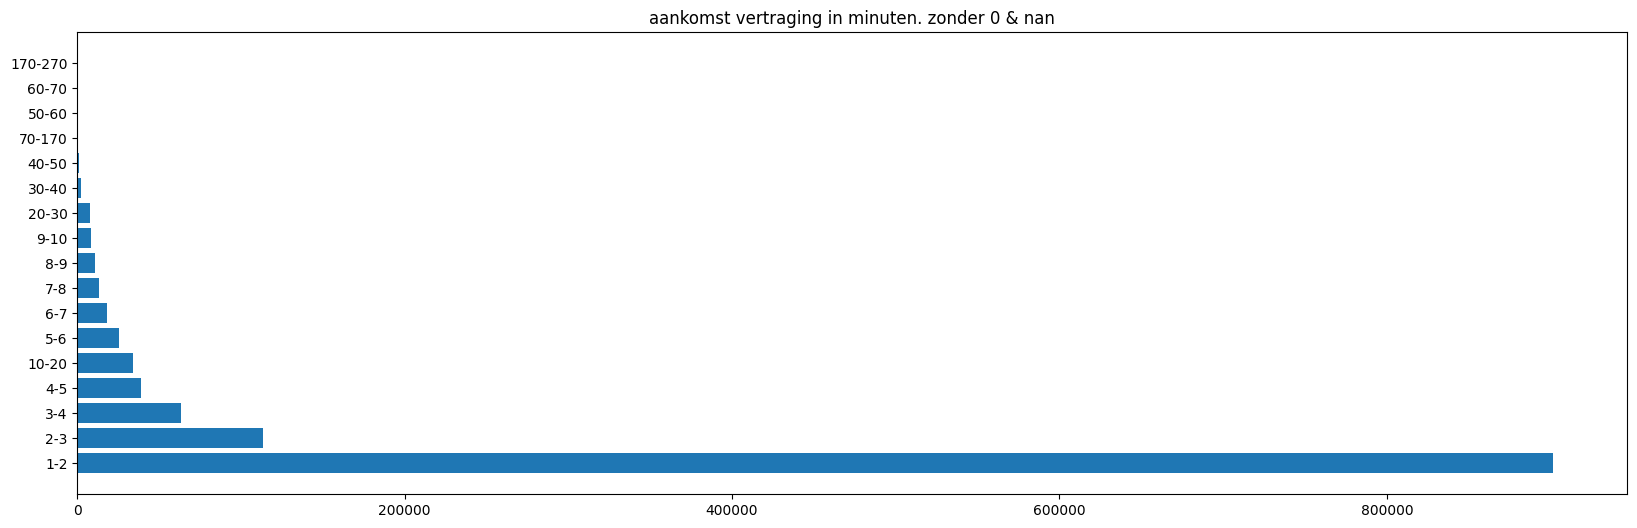

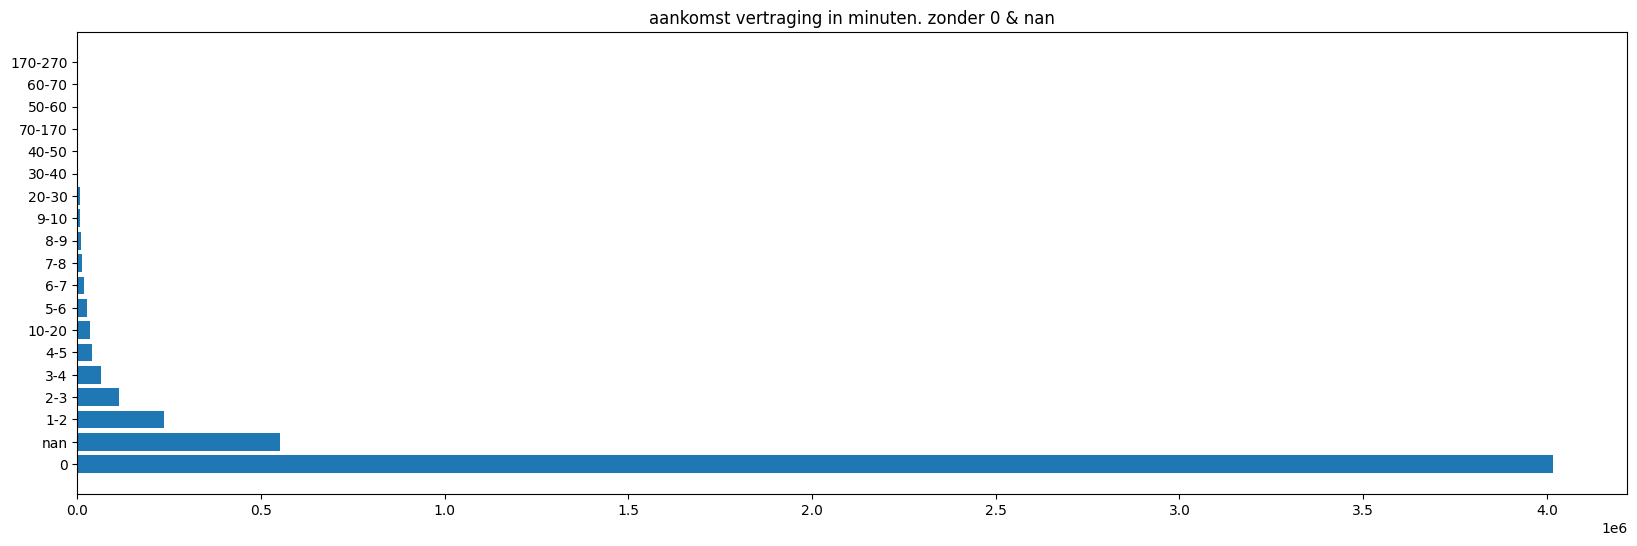

In [31]:
bins =  list(range(1, 10, 1)) + list(range(10, 70, 10)) + list(range(70, int(Train_trafic_2023['Stop:Departure delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels

bins = [0] + bins 

counts = pd.cut(Train_trafic_2023['Stop:Departure delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

Uit de grafieken hierboven blijkt dat de meeste treinen op tijd vertrekken van hun locatie. Houd er rekening mee dat zowel '0' als 'nan' aangeven dat er geen vertraging is gemeld.

Als ik de 'nan' en '0' weghaal, blijkt dat de vertraging voornamelijk binnen de 10 minuten ligt.

Maar dit hierboven betreft alleen de vertrekvertraging. Hieronder heb ik de aankomstvertraging op dezelfde manier geanalyseerd.

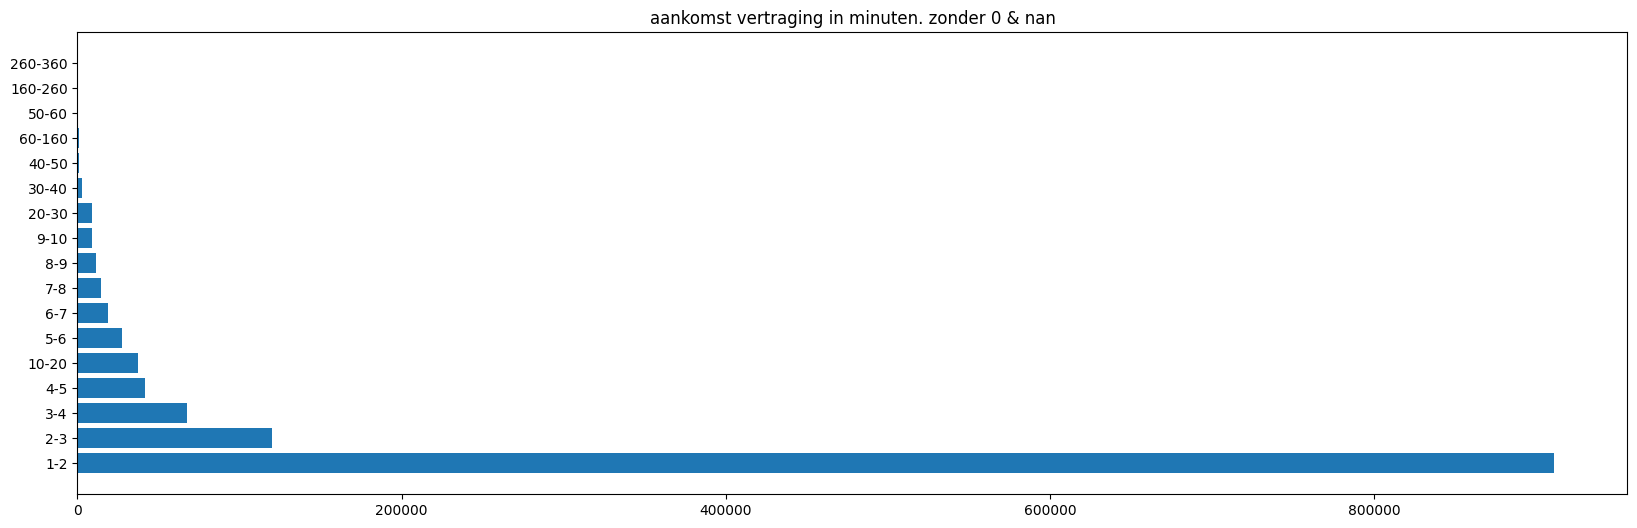

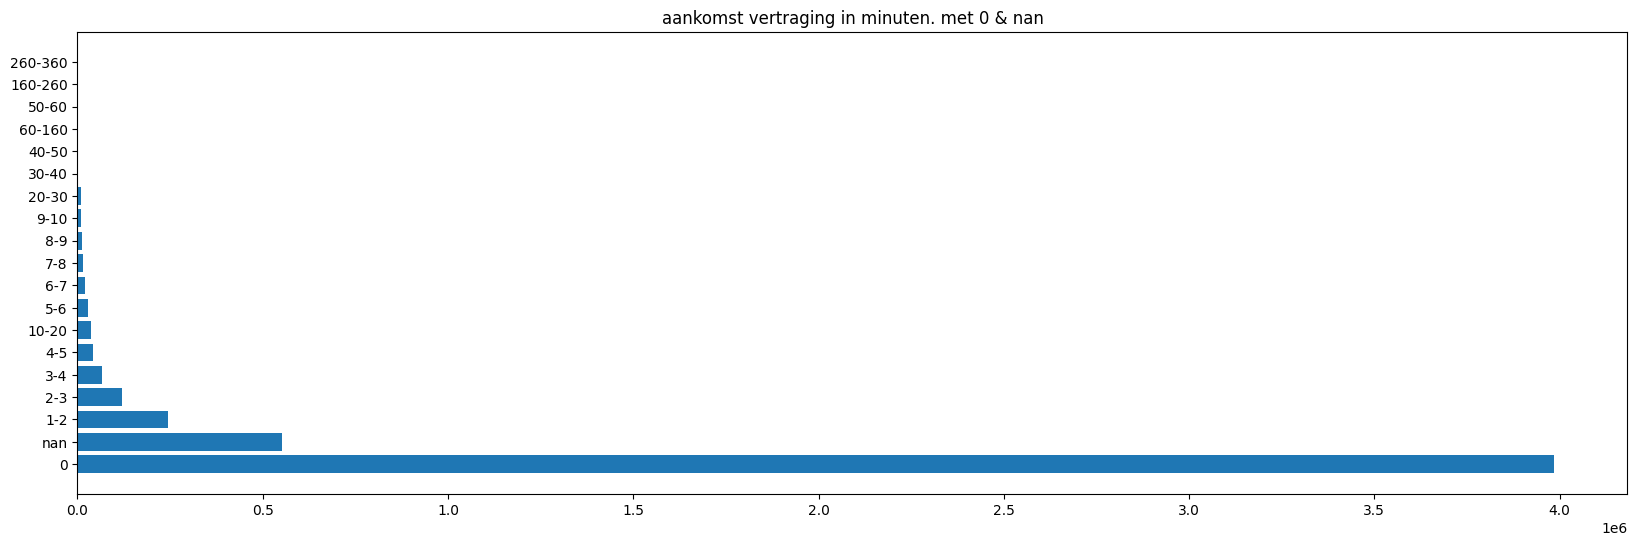

In [32]:
bins = list(range(1, 10, 1)) + list(range(10, 60, 10)) + list(range(60, int(Train_trafic_2023['Stop:Arrival delay'].max()) +100, 100))

labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).dropna().astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. zonder 0 & nan')
plt.show()

labels = ['0'] + labels 

bins = [0] + bins

counts = pd.cut(Train_trafic_2023['Stop:Arrival delay'], bins=bins, labels=labels, include_lowest=True).astype(str).value_counts(sort=True)

plt.figure(figsize=(20,6))
plt.barh( counts.index, counts)
plt.title(label='aankomst vertraging in minuten. met 0 & nan')
plt.show()

Als ik naar de vier grafieken kijk, lijken ze goed overeen te komen. Dit betekent dat als een trein meestal te laat aankomt, hij waarschijnlijk ook te laat zal vertrekken.

Met de tabel hieronder ga ik kijken of er op een bepaalde lijn meer vertraging is dan op een andere. Hierbij moet ik wel oppassen en controleren dat ik niet te vaak dezelfde lijn meeneem. 
Aangezien er is aangegeven dat een RDT-ID meerdere keren kan voorkomen op verschillende dagen, moet ik eerst alles goed bij elkaar zetten. 
Ik neem het gemiddelde omdat ik de gemiddelde vertraging van de ritten op een dag wil zien.

Service:Date  Stop:Arrival delay
0    2023-01-01            0.680368
1    2023-01-02            0.596654
2    2023-01-03            0.565669
3    2023-01-04            0.781114
4    2023-01-05            0.673781
..          ...                 ...
85   2023-03-27            0.799672
86   2023-03-28            0.964126
87   2023-03-29            0.642580
88   2023-03-30            0.710096
89   2023-03-31            0.702228

[90 rows x 2 columns]

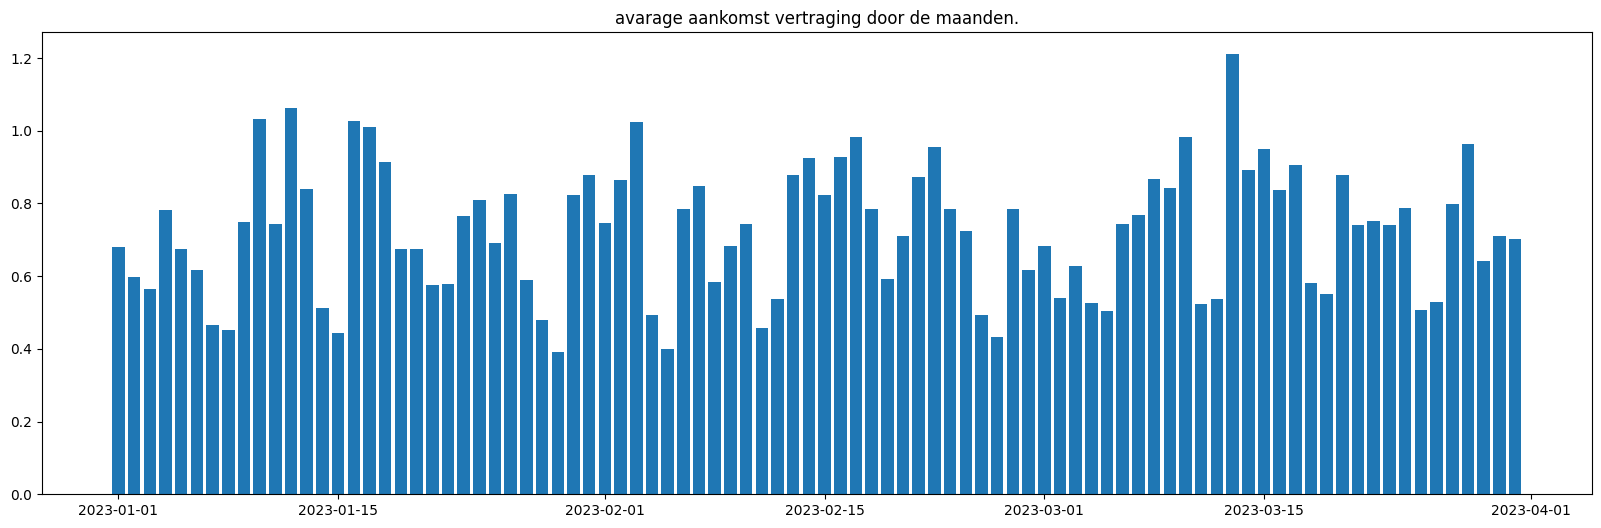

In [33]:
grouped = Train_trafic_2023.groupby(['Service:Date', 'Service:RDT-ID'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

grouped = df_avarage_delay_day.groupby(['Service:Date'])['Stop:Arrival delay'].mean()

df_avarage_delay_day = grouped.reset_index(name='Stop:Arrival delay')

display(df_avarage_delay_day)

plt.figure(figsize=(20,6))
plt.bar( df_avarage_delay_day['Service:Date'], df_avarage_delay_day['Stop:Arrival delay'])
plt.title(label='avarage aankomst vertraging door de maanden.')
plt.show()

In de grafiek hierboven is te zien dat de gemiddelde aankomstvertraging varieert gedurende de maanden. \
Dit kan belangrijk zijn voor het testen van de invloed van weersomstandigheden.

### 🌥️ Het weer
Er zijn veel kolommen in de weergegevens en ik ga eerst bepalen wat nodig is en wat niet. Daarvoor ga ik het gemiddelde berekenen en kijken hoe dicht dat bij het antwoord ligt. Als het dichtbij genoeg is, kan ik concluderen dat het gemiddelde representatief is voor heel Nederland. Als dat niet het geval is, moet ik even nadenken over wat ik dan ga doen.

In [34]:
grouped = weather_2023.groupby(by=['start_time']).mean()

db_weather_single_day = grouped.reset_index()

db_weather_single_day = db_weather_single_day.drop(columns=['STN'])

display(db_weather_single_day.head(24))

df_first_date = weather_2023[weather_2023['start_time'] == weather_2023['start_time'].min()]

display(df_first_date[df_first_date['temp'].notna()].sort_values('temp'))


start_time          DD          FH          FF          FX  \
0  2023-01-01 00:00:00+01:00  215.555556  110.666667  110.000000  172.222222   
1  2023-01-01 01:00:00+01:00  215.333333  108.000000  106.444444  167.333333   
2  2023-01-01 02:00:00+01:00  220.222222  107.333333  106.888889  168.000000   
3  2023-01-01 03:00:00+01:00  223.111111  104.000000  103.333333  165.111111   
4  2023-01-01 04:00:00+01:00  224.444444   99.111111   99.111111  158.444444   
5  2023-01-01 05:00:00+01:00  224.666667   95.333333   94.222222  148.444444   
6  2023-01-01 06:00:00+01:00  224.666667   91.333333   89.555556  140.222222   
7  2023-01-01 07:00:00+01:00  222.666667   87.111111   83.777778  134.444444   
8  2023-01-01 08:00:00+01:00  219.111111   81.777778   81.555556  127.555556   
9  2023-01-01 09:00:00+01:00  215.111111   76.666667   76.444444  119.555556   
10 2023-01-01 10:00:00+01:00  216.222222   78.444444   80.222222  120.000000   
11 2023-01-01 11:00:00+01:00  218.444444   78.666667   77.777778  122.888889   
12 2023-01-01 12:00:00+01:00  218.666667   77.555556   74.222222  119.555556   
13 2023-01-01 13:00:00+01:00  212.222222   68.000000   63.777778  107.555556   
14 2023-01-01 14:00:00+01:00  201.555556   59.111111   54.888889   92.666667   
15 2023-01-01 15:00:00+01:00  190.000000   52.000000   49.777778   82.000000   
16 2023-01-01 16:00:00+01:00  182.000000   48.888889   49.777778   76.666667   
17 2023-01-01 17:00:00+01:00  176.000000   49.111111   49.555556   78.222222   
18 2023-01-01 18:00:00+01:00  172.000000   49.333333   49.555556   78.444444   
19 2023-01-01 19:00:00+01:00  173.555556   48.222222   48.222222   78.222222   
20 2023-01-01 20:00:00+01:00  187.333333   41.333333   40.666667   76.222222   
21 2023-01-01 21:00:00+01:00  167.555556   40.444444   40.000000   73.777778   
22 2023-01-01 22:00:00+01:00  172.000000   41.777778   43.555556   70.000000   
23 2023-01-01 23:00:00+01:00  171.777778   43.777778   42.444444   72.444444   

          temp        T10N         TD       SQ         Q  ...     VV     N  \
0   140.617647         NaN  80.382353  0.00000   0.00000  ...  73.28  8.00   
1   138.029412         NaN  80.764706  0.00000   0.00000  ...  74.28  8.00   
2   135.529412         NaN  79.941176  0.00000   0.00000  ...  74.12  8.00   
3   131.323529         NaN  80.911765  0.00000   0.00000  ...  73.20  7.95   
4   125.970588         NaN  79.970588  0.00000   0.00000  ...  73.88  8.00   
5   122.558824  114.294118  76.294118  0.00000   0.00000  ...  73.08  8.00   
6   117.941176         NaN  75.352941  0.00000   0.00000  ...  70.80  8.00   
7   113.647059         NaN  75.970588  0.00000   0.25000  ...  69.88  8.00   
8   112.441176         NaN  78.558824  0.18750   5.62500  ...  69.40  8.00   
9   114.911765         NaN  81.676471  2.62500  25.12500  ...  69.56  8.00   
10  118.764706         NaN  83.588235  3.25000  40.75000  ...  70.64  7.90   
11  120.529412  102.852941  84.882353  1.46875  42.56250  ...  71.48  7.95   
12  121.382353         NaN  84.088235  2.00000  38.59375  ...  71.24  8.00   
13  119.647059         NaN  83.529412  1.06250  23.28125  ...  71.04  8.00   
14  116.352941         NaN  83.352941  1.15625  10.03125  ...  70.52  8.00   
15  113.617647         NaN  83.647059  0.00000   1.18750  ...  69.88  8.00   
16  111.058824         NaN  86.264706  0.00000   0.00000  ...  68.64  8.00   
17  108.735294  100.294118  89.058824  0.00000   0.00000  ...  67.32  8.00   
18  105.764706         NaN  92.147059  0.00000   0.00000  ...  65.08  8.00   
19  104.058824         NaN  93.617647  0.00000   0.00000  ...  62.68  8.00   
20  101.941176         NaN  93.500000  0.00000   0.00000  ...  60.88  8.00   
21  102.264706         NaN  94.764706  0.00000   0.00000  ...  61.36  8.00   
22  105.029412         NaN  95.470588  0.00000   0.00000  ...  60.68  8.00   
23  107.970588   95.647059  96.911765  0.00000   0.00000  ...  59.48  8.00   

            U         WW        IX    M     R    S    O    Y  
0  

STN                start_time     DD     FH     FF     FX   temp  T10N  \
17280  251 2023-01-01 00:00:00+01:00  220.0  140.0  130.0  190.0  108.0   NaN   
6480   235 2023-01-01 00:00:00+01:00  220.0  120.0  120.0  180.0  112.0   NaN   
10800  242 2023-01-01 00:00:00+01:00  220.0  160.0  150.0  210.0  114.0   NaN   
25920  267 2023-01-01 00:00:00+01:00  220.0  130.0  130.0  200.0  121.0   NaN   
19440  257 2023-01-01 00:00:00+01:00    NaN    NaN    NaN    NaN  123.0   NaN   
49680  286 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  170.0  128.0   NaN   
36720  277 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  200.0  130.0   NaN   
32400  273 2023-01-01 00:00:00+01:00  220.0   80.0   70.0  130.0  131.0   NaN   
56160  310 2023-01-01 00:00:00+01:00  200.0  140.0  140.0  180.0  131.0   NaN   
30240  270 2023-01-01 00:00:00+01:00  230.0  140.0  140.0  230.0  132.0   NaN   
43200  280 2023-01-01 00:00:00+01:00  210.0  110.0  100.0  190.0  133.0   NaN   
73440  330 2023-01-01 00:00:00+01:00  210.0  130.0  120.0  210.0  135.0   NaN   
15120  249 2023-01-01 00:00:00+01:00  230.0  140.0  130.0  230.0  136.0   NaN   
8640   240 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  150.0  138.0   NaN   
41040  279 2023-01-01 00:00:00+01:00  220.0   90.0   90.0  150.0  139.0   NaN   
28080  269 2023-01-01 00:00:00+01:00  220.0  100.0  110.0  170.0  141.0   NaN   
2160   215 2023-01-01 00:00:00+01:00  220.0  110.0  130.0  200.0  142.0   NaN   
79920  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
66960  319 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  180.0  145.0   NaN   
69120  323 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  160.0  145.0   NaN   
95040  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
82080  348 2023-01-01 00:00:00+01:00  220.0  120.0  130.0  180.0  147.0   NaN   
75600  340 2023-01-01 00:00:00+01:00  220.0   70.0   80.0  140.0  148.0   NaN   
38880  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
86400  356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
51840  290 2023-01-01 00:00:00+01:00  210.0   80.0   70.0  150.0  152.0   NaN   
34560  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
45360  283 2023-01-01 00:00:00+01:00  210.0   70.0   70.0  130.0  154.0   NaN   
84240  350 2023-01-01 00:00:00+01:00  210.0   90.0   90.0  150.0  154.0   NaN   
23760  260 2023-01-01 00:00:00+01:00  220.0   80.0  100.0  160.0  155.0   NaN   
92880  377 2023-01-01 00:00:00+01:00  210.0   90.0   80.0  160.0  155.0   NaN   
90720  375 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  160.0  162.0   NaN   
88560  370 2023-01-01 00:00:00+01:00  220.0  110.0  120.0  190.0  163.0   NaN   
97200  391 2023-01-01 00:00:00+01:00  220.0   50.0   50.0  120.0  163.0   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
17280  88.0  0.0  ...  58.0  NaN  87.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
6480   95.0  0.0  ...  56.0  8.0  89.0  52.0   7  0.0  1.0  0.0  0.0  0.0  
10800  91.0  NaN  ...  57.0  8.0  86.0  10.0   7  0.0  0.0  0.0  0.0  0.0  
25920  89.0  0.0  ...  64.0  8.0  81.0  57.0   7  0.0  1.0  0.0  0.0  0.0  
19440  83.0  0.0  ...   NaN  NaN  76.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
49680  98.0  0.0  ...   NaN  NaN  82.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
36720  92.0  0.0  ...   NaN  NaN  78.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
32400  93.0  0.0  ...  64.0  NaN  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
56160  79.0  0.0  ...  75.0  8.0  70.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
30240  94.0  0.0  ...  74.0  8.0  78.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
43200  94.0  0.0  ...  71.0  8.0  77.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
73440  78.0  0.0  ...   NaN  NaN  68.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
15120  98.0  0.0  ...  63.0  NaN  77.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
8640   92.0  0.0  ...  69.0  8.0  73.0  81.0   7  0.0  1.0  0.0  0.0  0.0  
41040  92.0  0.0  ...  75.0  8.

Het lijkt erop dat er met de temperatuur een verschil van ongeveer 4 graden is tussen de hoogste en laagste temperatuur. Hoewel een verschil van 4 graden niet veel lijkt, kan het ervoor zorgen dat mijn data niet meer klopt. Het lijkt er dus op dat ik toch het verschil tussen de stations moet vinden en het dichtstbijzijnde weerstation moet bepalen. Daarbij moet ik ook rekening houden met het tijdstip van de meting.


### 🏟️ Treinstations 

Allereerst moet ik bepalen welke treinstations ik nodig heb voor mijn datasets. Dat is wat ik hieronder doe. 
Ik neem de stationscodes van het treinverkeer en de codes van de treinstations in de locatiedataset en kijk welke er overeenkomen.

In [35]:
train_station_locations = train_station_locations[train_station_locations['code'].isin(Train_trafic_2023['Stop:Station code'])]

display(train_station_locations)

id  code      uic  name_short       name_medium              name_long  \
0    266    HT  8400319   Den Bosch  's-Hertogenbosch       's-Hertogenbosch   
1    269   HTO  8400320  Dn Bosch O  's-Hertogenb. O.  's-Hertogenbosch Oost   
2    227   HDE  8400388    't Harde          't Harde               't Harde   
3      8  AHBF  8015345      Aachen        Aachen Hbf             Aachen Hbf   
4    818    AW  8015199    Aachen W       Aachen West            Aachen West   
..   ...   ...      ...         ...               ...                    ...   
585  677   ZUE  8503000   Zürich HB         Zürich HB              Zürich HB   
586  534    ZP  8400744     Zutphen           Zutphen                Zutphen   
587  541   ZWD  8400752  Zwijndrcht       Zwijndrecht            Zwijndrecht   
589  532    ZL  8400747      Zwolle            Zwolle                 Zwolle   
590  815  ZLSH  8400746  Stadshagen        Stadshagen      Zwolle Stadshagen   

                     slug country                       type    geo_lat  \
0         s-hertogenbosch      NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost      NL           stoptreinstation  51.700554   
2                 t-harde      NL           stoptreinstation  52.409168   
3              aachen-hbf       D  knooppuntIntercitystation  50.767800   
4             aachen-west       D           stoptreinstation  50.780360   
..                    ...     ...                        ...        ...   
585             zurich-hb      CH           intercitystation  47.378190   
586               zutphen      NL  knooppuntIntercitystation  52.145279   
587           zwijndrecht      NL           stoptreinstation  51.814999   
589                zwolle      NL  knooppuntIntercitystation  52.504723   
590     zwolle-stadshagen      NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
585  8.539200  
586  6.194167  
587  4.641667  
589  6.091944  
590  6.051460  

[546 rows x 11 columns]

Met deze informatie kan ik mijn treinstations coördinaten geven, zodat ik het dichtstbijzijnde weerstation kan gebruiken.

Maar om dat te testen, voer ik hier eerst een test uit gebaseerd op één meetmoment.

Hier gebruik ik de BallTree-functie van de 'neighbors'-functies van sklearn. Hiermee probeer ik de temperaturen van de stations te ontdekken.

De 'haversine'-metric is een goede metric omdat het de afstand tussen twee locaties kan berekenen.

Ik moet alleen voor de 'haversine'-metric de invoerinformatie omzetten naar de radiaalvorm, gelukkig heeft numpy daar een goede functie voor.

Uiteindelijk doe ik dit om een zo dicht mogelijk weerstation te krijgen. Dit heb ik nodig om te bepalen of de vertragingen in het treinverkeer een verband hebben met het weer.


In [36]:
from sklearn.neighbors import BallTree

df_mergid_first_date_stations = df_first_date.merge(weather_station_location, on='STN', how='inner')

df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']] = np.radians(df_mergid_first_date_stations[['LAT(north)', 'LON(east)']])
train_station_locations[['geo_lat_radians', 'geo_lng_radians']] = np.radians(train_station_locations[['geo_lat', 'geo_lng']])

tree = BallTree(df_mergid_first_date_stations[['LAT(north)_radians', 'LON(east)_radians']].dropna().values, metric='haversine')

indices = tree.query(train_station_locations[['geo_lat_radians', 'geo_lng_radians']].dropna().values, return_distance=False, k=1)

nearest_neighbors_weather_station_location = df_mergid_first_date_stations.iloc[indices.flatten()]

train_station_locations.reset_index(drop=True, inplace=True)
nearest_neighbors_weather_station_location.reset_index(drop=True, inplace=True)

combined_df = pd.concat([nearest_neighbors_weather_station_location, train_station_locations], axis=1)

display(combined_df.drop(columns=['geo_lat_radians', 'geo_lng_radians', 'LAT(north)_radians', 'LON(east)_radians', 'name_short', 'name_medium', 'name_long', 'id', 'code', 'uic']))


STN                start_time     DD     FH     FF     FX   temp  T10N  \
0    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
1    356 2023-01-01 00:00:00+01:00  220.0  110.0  110.0  170.0  151.0   NaN   
2    278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
3    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
4    380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
..   ...                       ...    ...    ...    ...    ...    ...   ...   
541  380 2023-01-01 00:00:00+01:00  210.0  100.0   90.0  150.0  147.0   NaN   
542  275 2023-01-01 00:00:00+01:00  220.0  100.0   90.0  150.0  153.0   NaN   
543  344 2023-01-01 00:00:00+01:00  210.0  100.0  110.0  180.0  143.0   NaN   
544  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   
545  278 2023-01-01 00:00:00+01:00  220.0   70.0   60.0  130.0  150.0   NaN   

       TD   SQ  ...    Y  LON(east)  LAT(north)  ALT(m)        NAME  \
0    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
1    80.0  0.0  ...  NaN      5.146      51.859     0.7   Herwijnen   
2    83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
3    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
4    42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
..    ...  ...  ...  ...        ...         ...     ...         ...   
541  42.0  0.0  ...  0.0      5.762      50.906   114.3  Maastricht   
542  76.0  0.0  ...  0.0      5.873      52.056    48.2      Deelen   
543  88.0  0.0  ...  0.0      4.447      51.962    -4.3   Rotterdam   
544  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   
545  83.0  0.0  ...  NaN      6.259      52.435     3.6       Heino   

                     slug  country                       type    geo_lat  \
0         s-hertogenbosch       NL  knooppuntIntercitystation  51.690480   
1    s-hertogenbosch-oost       NL           stoptreinstation  51.700554   
2                 t-harde       NL           stoptreinstation  52.409168   
3              aachen-hbf        D  knooppuntIntercitystation  50.767800   
4             aachen-west        D           stoptreinstation  50.780360   
..                    ...      ...                        ...        ...   
541             zurich-hb       CH           intercitystation  47.378190   
542               zutphen       NL  knooppuntIntercitystation  52.145279   
543           zwijndrecht       NL           stoptreinstation  51.814999   
544                zwolle       NL  knooppuntIntercitystation  52.504723   
545     zwolle-stadshagen       NL           stoptreinstation  52.527640   

      geo_lng  
0    5.293620  
1    5.318333  
2    5.893611  
3    6.091499  
4    6.070715  
..        ...  
541  8.539200  
542  6.194167  
543  4.641667  
544  6.091944  
545  6.051460  

[546 rows x 33 columns]

Uit de test hierboven kan ik concluderen dat ik met de weerstations en treinstationlocaties redelijk goed het dichtstbijzijnde weerstation van een treinstation kan vinden.

# 🎛️ Correlatie bekijken

Hier ga ik de correlatieplots van de datasets weergeven.

### 🚄 Treinverkeer 
Dit is de correlatieplot van het treinverkeer:

<Axes: >

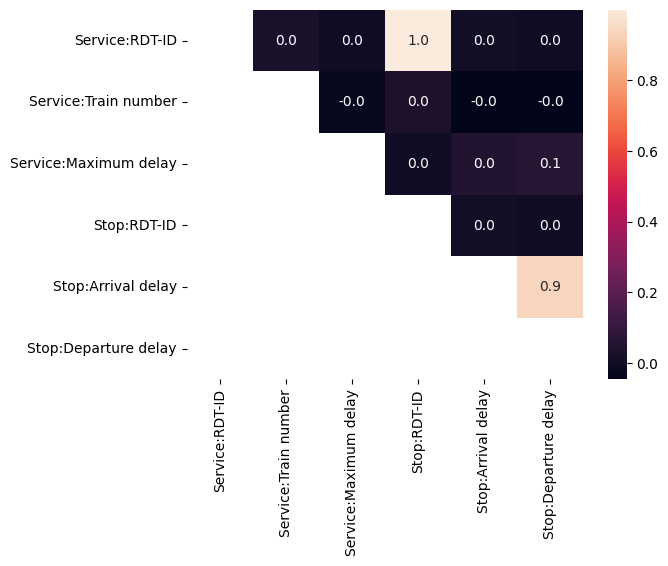

In [37]:
corr = Train_trafic_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()

mask = np.tril(corr)

sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Het lijkt erop dat als ik de correlatieplot van de afzonderlijke treininformatie maak, er een lage correlatie tussen de gegevens is. 
Hieronder ga ik een pairplot maken om te zien of ik er meer uit kan halen.

<Figure size 2000x2000 with 0 Axes>

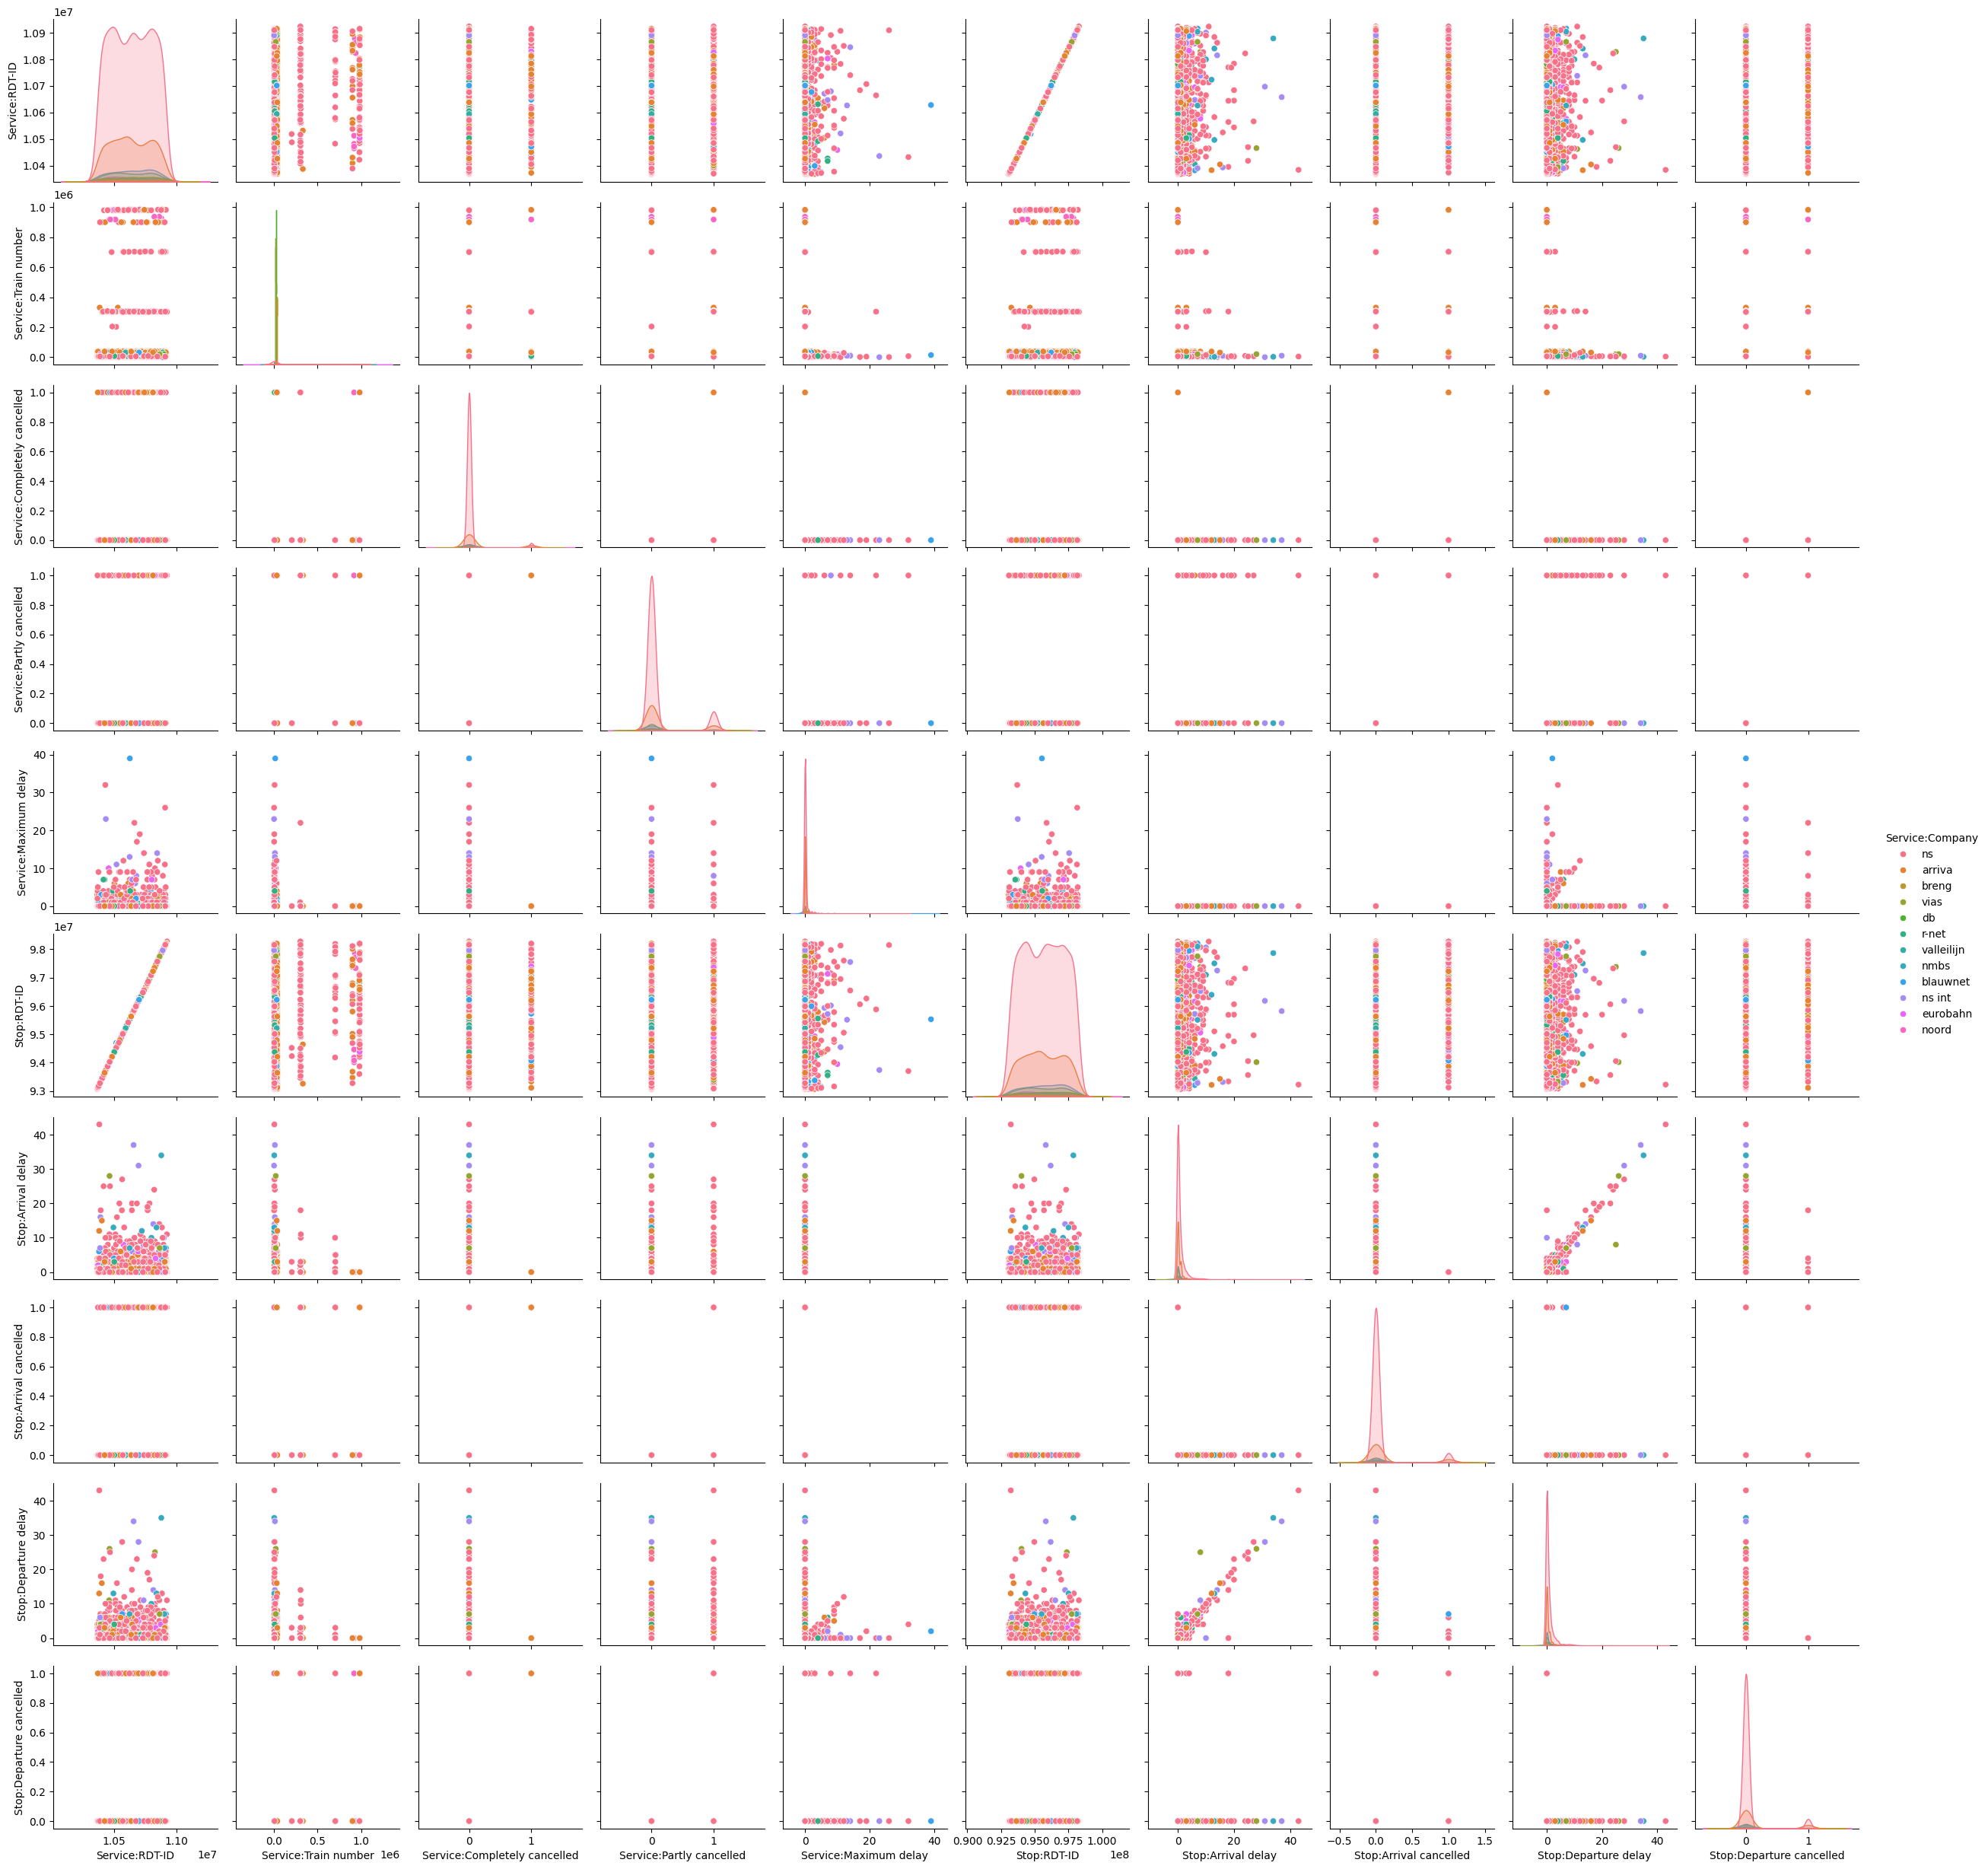

In [38]:
plt.figure(figsize=(20,20))
sns.pairplot(Train_trafic_2023.sample(frac=0.001), hue='Service:Company')

Hoewel ik de hoeveelheid data heb moeten verminderen, heb ik toch een goed gevoel over de inhoud van mijn dataset.

### 🌥️ het weer

<Axes: >

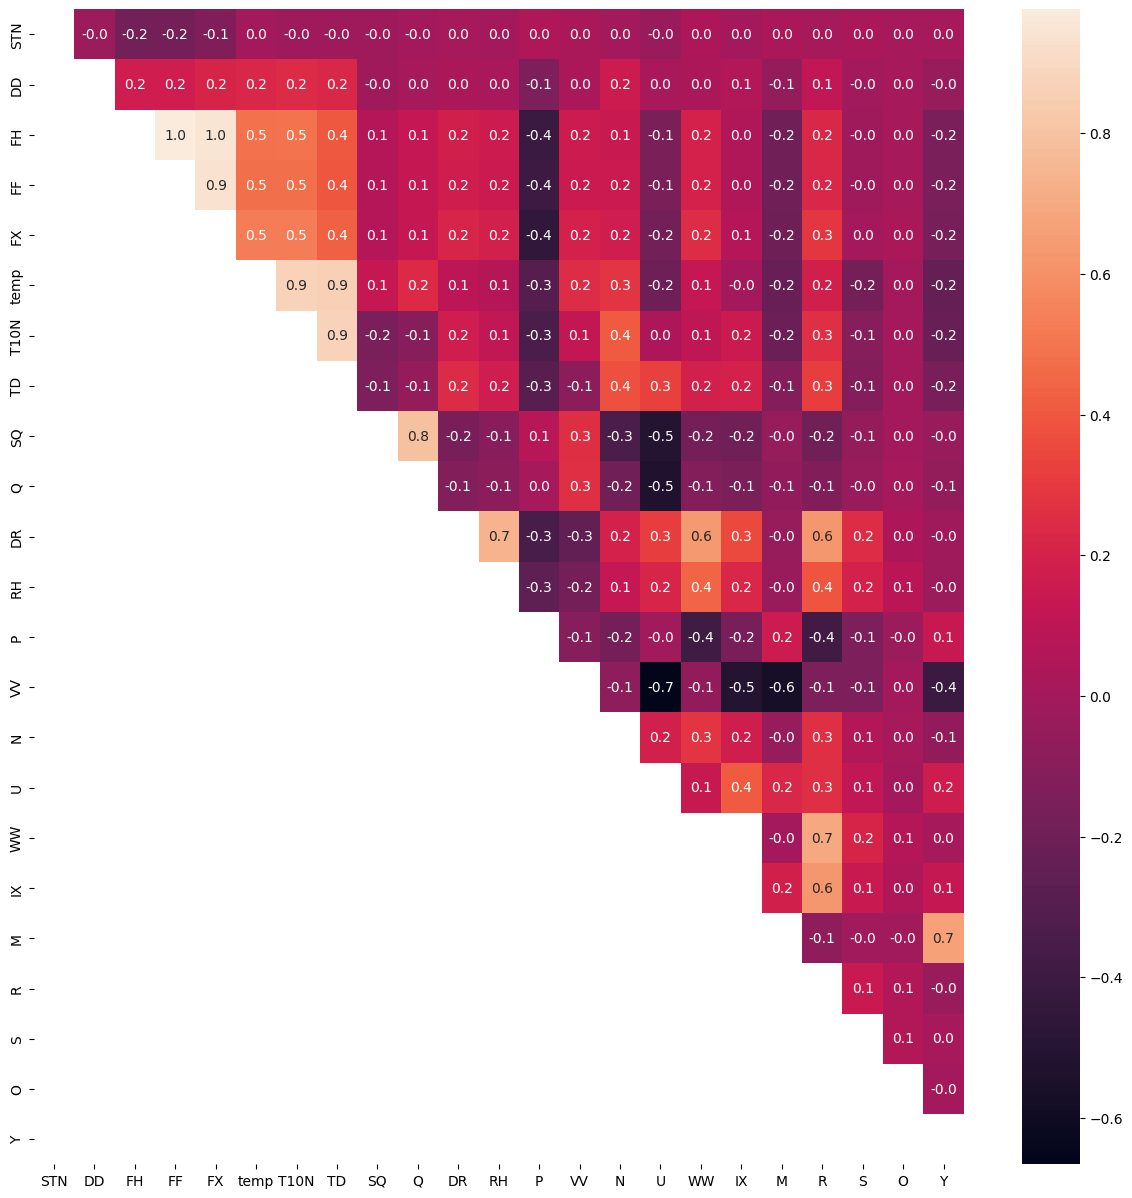

In [39]:
plt.subplots(figsize=(15, 15))

corr = weather_2023.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr);
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f",)

Het lijkt erop dat verschillende weerelementen een sterke relatie met elkaar hebben. Het gaat niet alleen om de hoeveelheid, maar ook om de elementen die naar verwachting met elkaar in verband staan. Bijvoorbeeld, de temperatuur en de minimale temperatuur elke 6 uur vertonen een sterke correlatie.

STN                start_time     DD     FH     FF     FX   temp  T10N  \
88492  356 2023-03-29 04:00:00+02:00  190.0   30.0   30.0   50.0   72.0   NaN   
87135  356 2023-01-31 15:00:00+01:00  270.0   70.0   70.0  110.0   83.0   NaN   
3988   215 2023-03-18 04:00:00+01:00  200.0   30.0   20.0   60.0   93.0   NaN   
93522  377 2023-01-27 18:00:00+01:00   20.0   30.0   30.0   50.0   40.0   NaN   
1209   209 2023-02-20 09:00:00+01:00  240.0  120.0  120.0  160.0    NaN   NaN   
...    ...                       ...    ...    ...    ...    ...    ...   ...   
62738  315 2023-01-05 02:00:00+01:00  260.0   90.0   90.0  130.0    NaN   NaN   
54643  308 2023-01-27 19:00:00+01:00    NaN    NaN    NaN    NaN    NaN   NaN   
86680  356 2023-01-12 16:00:00+01:00  230.0   90.0  100.0  150.0  107.0   NaN   
27661  267 2023-03-14 13:00:00+01:00  310.0  100.0  100.0  130.0   58.0   NaN   
1600   209 2023-03-08 16:00:00+01:00   90.0   70.0   60.0   90.0    NaN   NaN   

         TD   SQ  ...    VV    N     U    WW  IX    M    R    S    O    Y  
88492  34.0  0.0  ...   NaN  NaN  76.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
87135  58.0  3.0  ...   NaN  NaN  84.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
3988   84.0  0.0  ...  60.0  8.0  94.0  23.0   7  0.0  1.0  0.0  0.0  0.0  
93522   5.0  0.0  ...  75.0  8.0  77.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
1209    NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
...     ...  ...  ...   ...  ...   ...   ...  ..  ...  ...  ...  ...  ...  
62738   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
54643   NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  
86680  99.0  0.0  ...   NaN  NaN  94.0   NaN   6  NaN  NaN  NaN  NaN  NaN  
27661  -3.0  9.0  ...  76.0  7.0  64.0   NaN   5  0.0  0.0  0.0  0.0  0.0  
1600    NaN  NaN  ...   NaN  NaN   NaN   NaN   6  NaN  NaN  NaN  NaN  NaN  

[99 rows x 24 columns]

<Figure size 2000x2000 with 0 Axes>

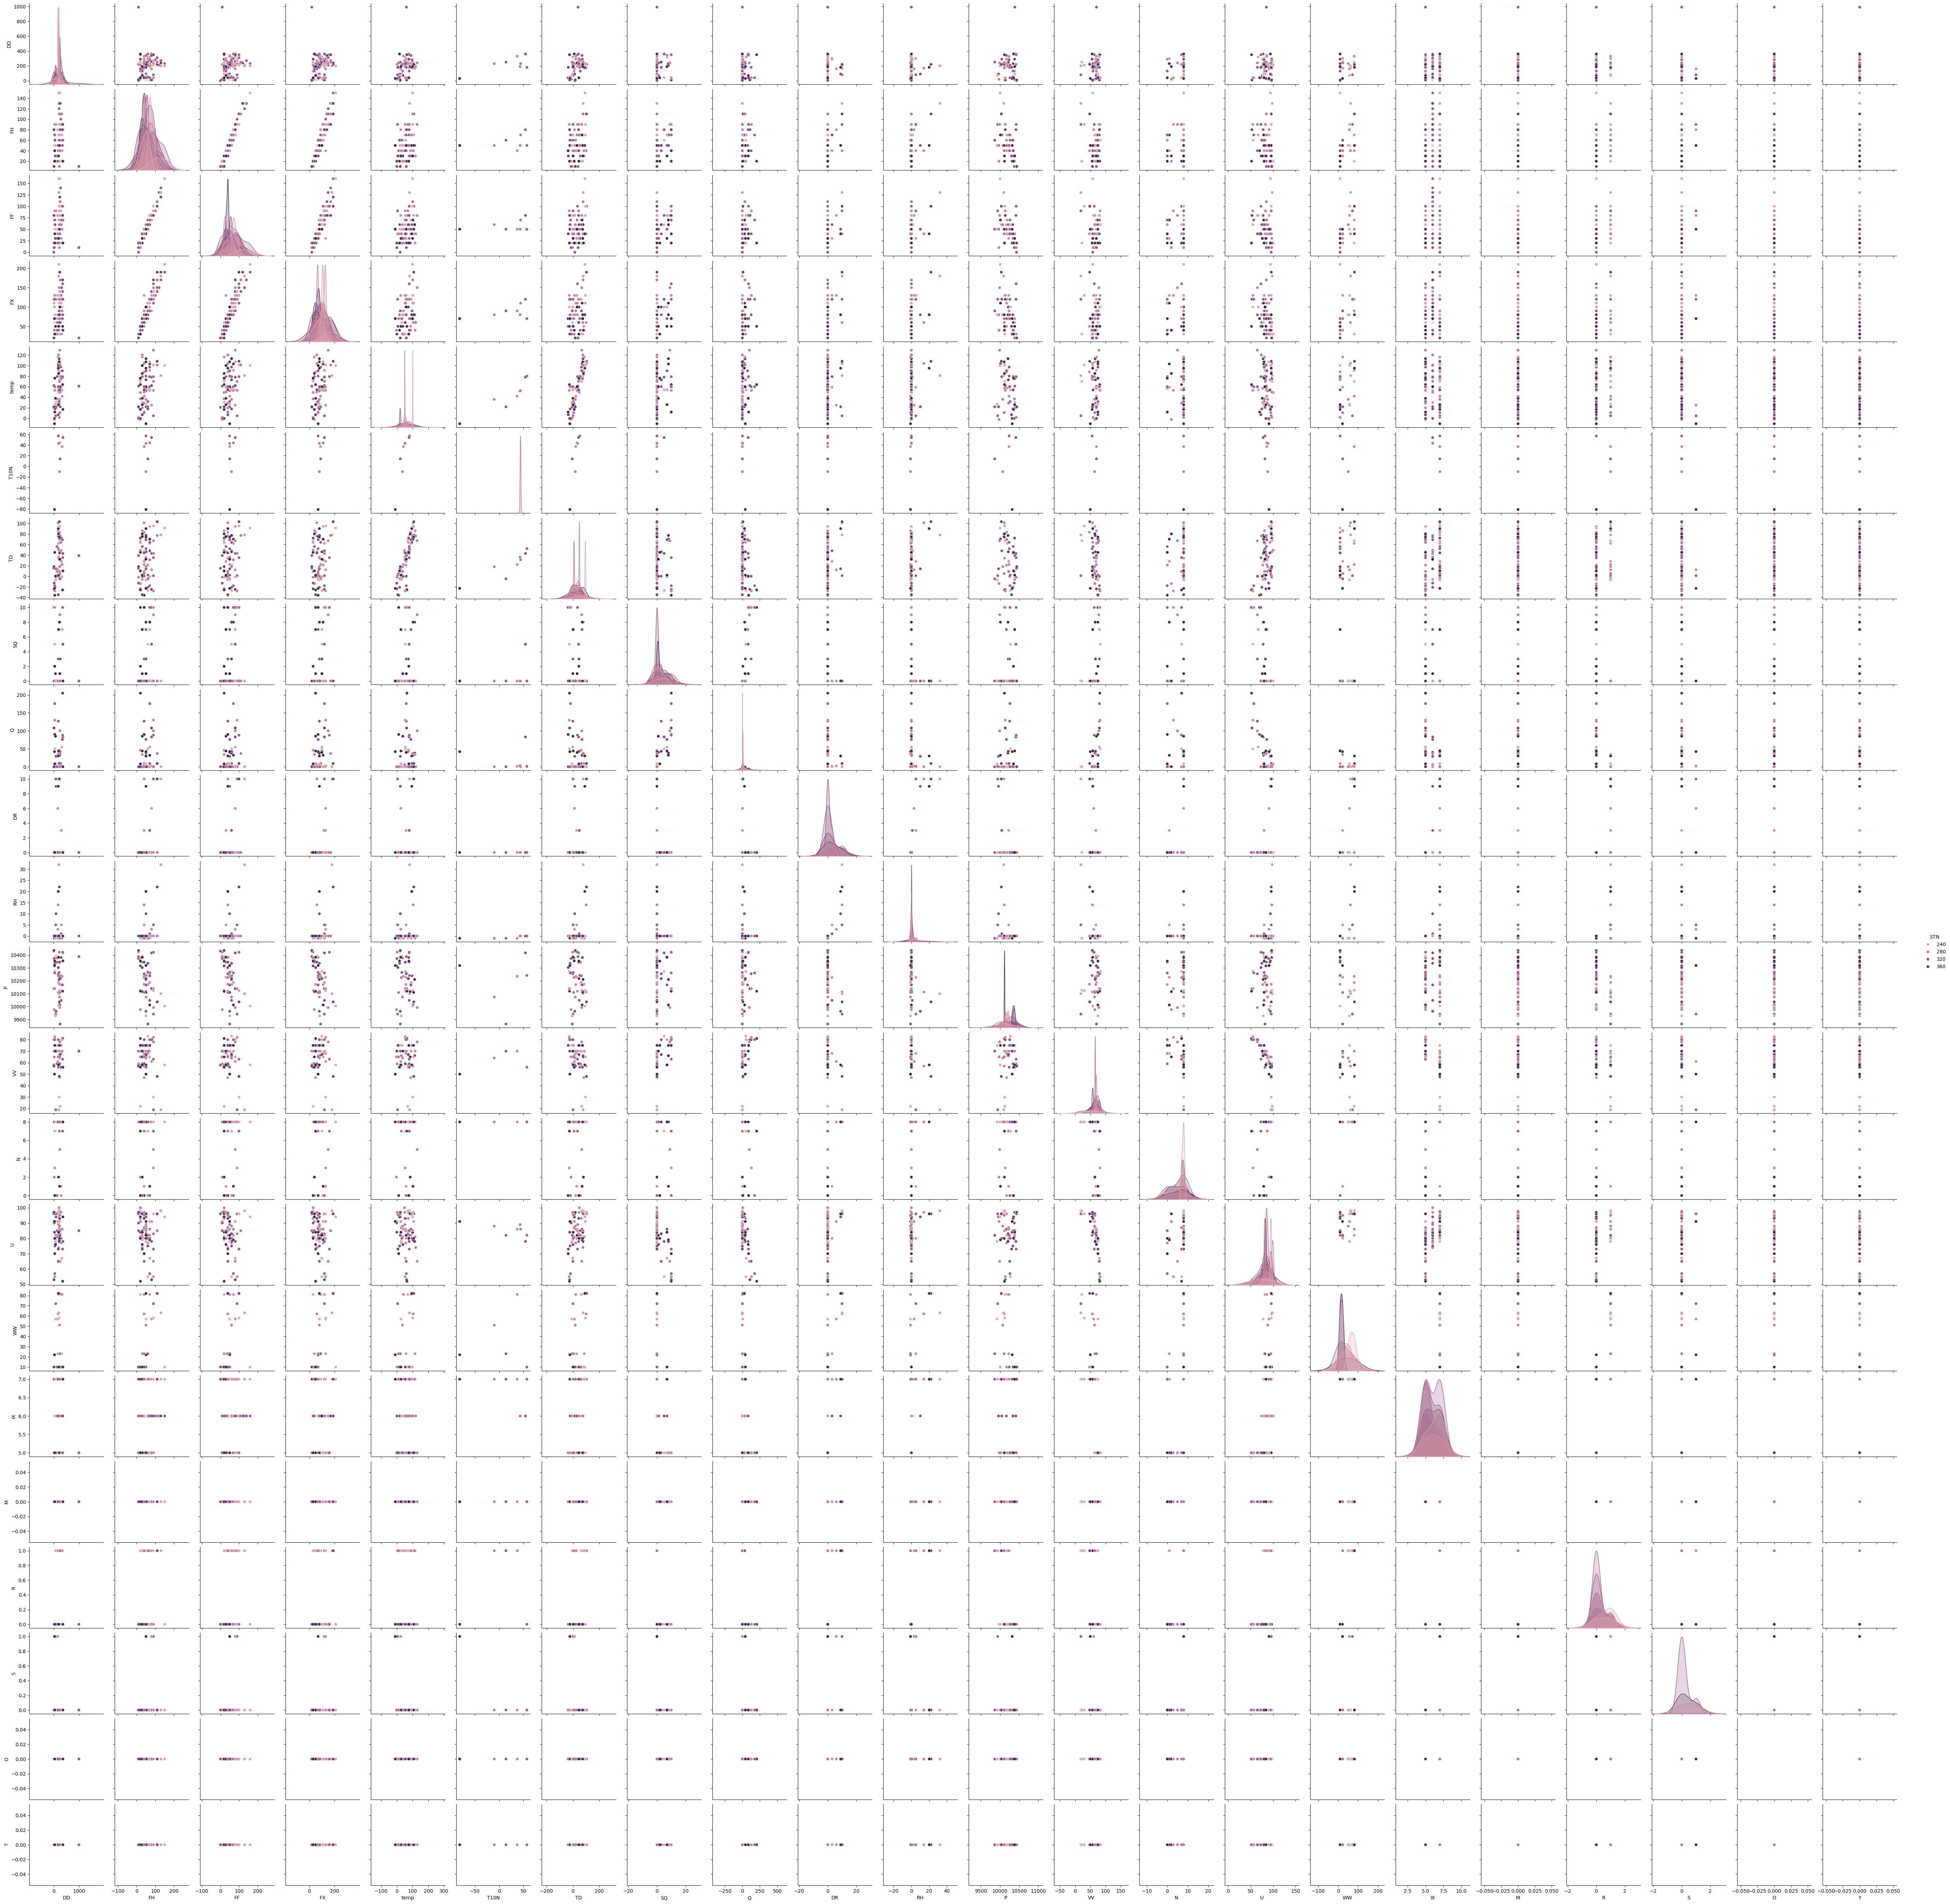

In [40]:
plt.figure(figsize=(20,20))
display(weather_2023.sample(frac=0.001))
sns.pairplot(weather_2023.sample(frac=0.001), hue='STN')

### 🏟️ trein station 

<Axes: >

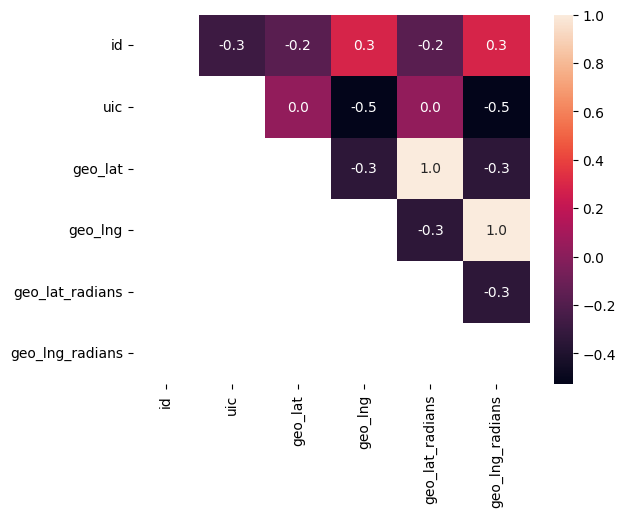

In [41]:
corr = train_station_locations.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr)
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Dit was meer om te kijken of ik iets terug zou krijgen, maar het geeft een goed voorbeeld van de gegevens.

# 🛠️ Preprocessing

Ik ga onderzoeken of ik de datasets kan samenvoegen, zodat ik één volledige dataset krijg met mijn informatie. \
Uiteraard moet de data op de juiste plek staan.

### 🚄&🏟️ Treinverkeer samenvoegen met treinstation
Hieronder ga ik al het treinverkeer voorzien van hun treinstationgegevens, zodat ik het later kan samenvoegen met het juiste weerstation. \
Hiervoor ga ik een nieuwe variabele aanmaken, zodat ik het meerdere keren kan uitvoeren zonder dat het de data hierboven verstoort. \
De samenvoeging zal worden gedaan door de twee datasets te joinen met de merge-functie van Panda's. \
De join zal alle gegevens van beide tabellen bevatten. Ik gebruik in de merge de stationscode die in beide tabellen voorkomt. Hoewel ze anders worden genoemd, zijn het allebei de stationscodes. \
Dit zou niet het moeilijkste moeten zijn, aangezien de datasets van dezelfde provider komen.

In [42]:
# train_station_locations , Train_trafic_2023
display(
   train_station_locations[train_station_locations['name_short']== "Nw A'dam"] 
)
train_trafic_with_locations = Train_trafic_2023.merge(right=train_station_locations, how='outer', left_on='Stop:Station code', right_on='code')
display(train_trafic_with_locations)


id code      uic name_short    name_medium        name_long  \
351  349  NaN  8400454   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                slug country              type    geo_lat   geo_lng  \
351  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   

     geo_lat_radians  geo_lng_radians  
351         0.920113         0.119531

Service:RDT-ID Service:Date Service:Type Service:Company  \
0              10368001   2023-01-01     sprinter              ns   
1              10368079   2023-01-01     sprinter              ns   
2              10368089   2023-01-01     sprinter              ns   
3              10368125   2023-01-01     sprinter              ns   
4              10368142   2023-01-01     sprinter              ns   
...                 ...          ...          ...             ...   
5142245        10915642   2023-03-31    stoptrein        blauwnet   
5142246        10915677   2023-03-31    sneltrein        blauwnet   
5142247        10915796   2023-03-31    stoptrein        blauwnet   
5142248        10915874   2023-03-31    stoptrein        blauwnet   
5142249        10915882   2023-03-31    stoptrein        blauwnet   

         Service:Train number  Service:Completely cancelled  \
0                        4026                         False   
1                        4037                         False   
2                        4035                         False   
3                        4030                         False   
4                        4028                         False   
...                       ...                           ...   
5142245                  8092                         False   
5142246                  3879                         False   
5142247                  8081                         False   
5142248                  8096                         False   
5142249                  8083                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                           False                      0     93070750   
1                           False                      0     93071464   
2                           False                      0     93071556   
3                           False                      0     93071943   
4                           False                      0     93072094   
...                           ...                    ...          ...   
5142245                     False                      0     98208124   
5142246                     False                      0     98208425   
5142247                     False                      0     98209348   
5142248                     False                      0     98209890   
5142249                     False                      0     98209958   

        Stop:Station code  ... name_short    name_medium        name_long  \
0                      AC  ...    Abcoude        Abcoude          Abcoude   
1                      AC  ...    Abcoude        Abcoude          Abcoude   
2                      AC  ...    Abcoude        Abcoude          Abcoude   
3                      AC  ...    Abcoude        Abcoude          Abcoude   
4                      AC  ...    Abcoude        Abcoude          Abcoude   
...                   ...  ...        ...            ...              ...   
5142245               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142246               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142247               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142248               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   
5142249               NaN  ...   Nw A'dam  Nw. Amsterdam  Nieuw Amsterdam   

                    slug country              type    geo_lat   geo_lng  \
0                abcoude      NL  stoptreinstation  52.278500  4.977000   
1                abcoude      NL  stoptreinstation  52.278500  4.977000   
2                abcoude      NL  stoptreinstation  52.278500  4.977000   
3                abcoude      NL  stoptreinstation  52.278500  4.977000   
4                abcoude      NL  stoptreinstation  52.278500  4.977000   
...                  ...     ...               ...        ...       ...   
5142245  nieuw-amsterdam      NL  sneltreinstation  52.718613  6.848611   
5142246  nieuw-amster

Voor deze verbinding heb ik ontdekt dat het station 'New Amsterdam' een stationscode heeft die 'NaN' is, en niet de variabele NaN. \
Maar na deze ontdekking verliep de verbinding vlekkeloos.


### 🌥️&🚄🏟️ Het weer samenvoegen met het al samengevoegde treinverkeer en stations

Voor deze taak zal ik waarschijnlijk machine learning moeten gebruiken om het juiste weerstation aan een treinstation te koppelen. \
Dit komt omdat een weerstation ook in de loop van de tijd kan veranderen, wat invloed heeft op het weer.

Als eerste stap ga ik kijken welk weerstation het dichtst bij welk treinstation ligt.

In [43]:
from sklearn.neighbors import BallTree
import numpy as np

# weather_station_location, train_trafic_with_locations, weather_2023

# Weather_With_location_time = weather_2023.merge(weather_station_location, on='STN', how='inner')

tree = BallTree(np.radians(weather_station_location[['LAT(north)', 'LON(east)']]), metric='haversine')
distances, indices = tree.query(np.radians(train_trafic_with_locations[['geo_lat', 'geo_lng']].dropna()), dualtree=True)

display(distances)
display(indices)
display(weather_2023)

array([[0.00211167],
       [0.00211167],
       [0.00211167],
       ...,
       [0.00295339],
       [0.00295339],
       [0.00295339]])

array([[ 5],
       [ 5],
       [ 5],
       ...,
       [21],
       [21],
       [21]], dtype=int64)

STN                start_time     DD     FH     FF     FX  temp  T10N  \
0      209 2023-01-01 00:00:00+01:00  220.0  140.0  150.0  170.0   NaN   NaN   
1      209 2023-01-01 01:00:00+01:00  220.0  130.0  130.0  170.0   NaN   NaN   
2      209 2023-01-01 02:00:00+01:00  240.0  140.0  130.0  200.0   NaN   NaN   
3      209 2023-01-01 03:00:00+01:00  220.0  120.0  130.0  170.0   NaN   NaN   
4      209 2023-01-01 04:00:00+01:00  230.0  130.0  140.0  170.0   NaN   NaN   
...    ...                       ...    ...    ...    ...    ...   ...   ...   
99355  391 2023-03-31 19:00:00+02:00  210.0   50.0   40.0  120.0  99.0   NaN   
99356  391 2023-03-31 20:00:00+02:00  220.0   40.0   50.0  100.0  99.0   NaN   
99357  391 2023-03-31 21:00:00+02:00  210.0   40.0   40.0  110.0  97.0   NaN   
99358  391 2023-03-31 22:00:00+02:00  220.0   40.0   40.0   90.0  95.0   NaN   
99359  391 2023-03-31 23:00:00+02:00  220.0   50.0   50.0  110.0  94.0  96.0   

         TD   SQ  ...  VV   N     U  WW  IX   M   R   S   O   Y  
0       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
1       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
2       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
3       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
4       NaN  NaN  ... NaN NaN   NaN NaN   6 NaN NaN NaN NaN NaN  
...     ...  ...  ...  ..  ..   ...  ..  ..  ..  ..  ..  ..  ..  
99355  88.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99356  86.0  0.0  ... NaN NaN  91.0 NaN   6 NaN NaN NaN NaN NaN  
99357  87.0  0.0  ... NaN NaN  93.0 NaN   6 NaN NaN NaN NaN NaN  
99358  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  
99359  88.0  0.0  ... NaN NaN  95.0 NaN   6 NaN NaN NaN NaN NaN  

[99360 rows x 24 columns]

Hierboven heb ik ervoor gezorgd dat ik weet welk weerstation het dichtst bij een treinstation staat. \
Deze informatie heb ik hieronder nodig om een dataset te creëren die alle gegevens van het weerstation bij de treingegevens voegt.

Hieronder ga ik de data samenvoegen zodat ik uiteindelijk één dataset heb waar alles in staat dat ik nodig zou moeten hebben. \
Dit doe ik door de dichtstbijzijnde tijd bij zijn dichtstbijzijnde weerstation te zoeken. Ik heb ervoor gekozen om voor het testen minder data te gebruiken, zodat ik sneller feedback krijg van mijn outputs.

En omdat het een grote dataset is ga ik hem opslaan naar een csv om hem dan te laten kiezen tussen de dataframe maken of de dataframe inladen van geschiedenis. \
uitijndelijk do ik dit om het te versnellen en ruimte in mijn RAM geheugen op te schonen.


In [2]:

CSV_save_location_full_data_weather_and_train = datafolder + 'Processed data/Weather and train station data.csv'

if(calculate_large_data): 
    combined_data = []

    for i, train_station in train_trafic_with_locations.iterrows():
        if(indices.size > i):
            nearest_weather_station = weather_station_location.iloc[indices[i][0]]
            nearest_weather_station = weather_2023[weather_2023['STN'] == nearest_weather_station.STN]
            if(nearest_weather_station['start_time'].count() > 0):
                if (pd.notnull(train_station['Stop:Arrival time'])):
                    time_diffs = abs(nearest_weather_station['start_time'] - train_station['Stop:Arrival time'])

                    nearest_time_index = time_diffs.idxmin()
                    nearest_weather_data = nearest_weather_station.loc[nearest_time_index]

                    combined_row = pd.concat([train_station, nearest_weather_data])
                    combined_data.append(combined_row)

    combined_df = pd.DataFrame(combined_data)

    combined_df.reset_index(drop=True, inplace=True)
    
    combined_df.to_csv(CSV_save_location_full_data_weather_and_train, index=False)
else:
    combined_df = pd.read_csv(CSV_save_location_full_data_weather_and_train, low_memory=False)


display(combined_df)
display(combined_df.dtypes)

Service:RDT-ID Service:Date Service:Type Service:Company  \
0              10368001   2023-01-01     sprinter              ns   
1              10368079   2023-01-01     sprinter              ns   
2              10368089   2023-01-01     sprinter              ns   
3              10368125   2023-01-01     sprinter              ns   
4              10368142   2023-01-01     sprinter              ns   
...                 ...          ...          ...             ...   
4288666        10894127   2023-03-28    stoptrein        blauwnet   
4288667        10894200   2023-03-28    stoptrein        blauwnet   
4288668        10894311   2023-03-28    stoptrein        blauwnet   
4288669        10894382   2023-03-28    stoptrein        blauwnet   
4288670        10894488   2023-03-28    stoptrein        blauwnet   

         Service:Train number  Service:Completely cancelled  \
0                        4026                         False   
1                        4037                         False   
2                        4035                         False   
3                        4030                         False   
4                        4028                         False   
...                       ...                           ...   
4288666                  8068                         False   
4288667                  8055                         False   
4288668                  8070                         False   
4288669                  8057                         False   
4288670                  8072                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
0                           False                      0     93070750   
1                           False                      0     93071464   
2                           False                      0     93071556   
3                           False                      0     93071943   
4                           False                      0     93072094   
...                           ...                    ...          ...   
4288666                     False                      0     98003158   
4288667                     False                      0     98003859   
4288668                     False                      0     98004967   
4288669                     False                      0     98005654   
4288670                     False                      0     98006751   

        Stop:Station code  ...    VV    N     U    WW IX    M    R    S    O  \
0                      AC  ...  73.0  8.0  74.0   NaN  5  0.0  0.0  0.0  0.0   
1                      AC  ...  74.0  8.0  74.0   NaN  5  0.0  0.0  0.0  0.0   
2                      AC  ...  73.0  8.0  74.0   NaN  5  0.0  0.0  0.0  0.0   
3                      AC  ...  74.0  8.0  74.0   NaN  5  0.0  0.0  0.0  0.0   
4                      AC  ...  73.0  8.0  74.0   NaN  5  0.0  0.0  0.0  0.0   
...                   ...  ...   ...  ...   ...   ... ..  ...  ...  ...  ...   
4288666               NaN  ...  84.0  4.0  58.0   NaN  5  0.0  0.0  0.0  0.0   
4288667               NaN  ...  83.0  8.0  64.0  51.0  7  0.0  1.0  0.0  0.0   
4288668               NaN  ...  83.0  8.0  64.0  51.0  7  0.0  1.0  0.0  0.0   
4288669               NaN  ...  80.0  8.0  69.0  81.0  7  0.0  1.0  0.0  0.0   
4288670               NaN  ...  83.0  8.0  64.0  51.0  7  0.0  1.0  0.0  0.0   

           Y  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  
...      ...  
4288666  0.0  
4288667  0.0  
4288668  0.0  
4288669  0.0  
4288670  0.0  

[4288671 rows x 54 columns]

Service:RDT-ID                    int64
Service:Date                     object
Service:Type                     object
Service:Company                  object
Service:Train number              int64
Service:Completely cancelled       bool
Service:Partly cancelled           bool
Service:Maximum delay             int64
Stop:RDT-ID                       int64
Stop:Station code                object
Stop:Station name                object
Stop:Arrival time                object
Stop:Arrival delay              float64
Stop:Arrival cancelled             bool
Stop:Departure time              object
Stop:Departure delay            float64
Stop:Departure cancelled         object
id                              float64
code                             object
uic                             float64
name_short                       object
name_medium                      object
name_long                        object
slug                             object
country                          object


even de tijden naar een datetime object zetten.

In [3]:
combined_df['Service:Date'] = pd.to_datetime(combined_df['Service:Date']).dt.dayofweek
combined_df['Stop:Departure time'] = pd.to_datetime(combined_df['Stop:Departure time'], utc=True).dt.dayofweek
combined_df['Stop:Arrival time'] = pd.to_datetime(combined_df['Stop:Arrival time'], utc=True).dt.dayofweek

Hieronder verwijder ik de rijen waar de het type van het verkeer niet een goede verandering heeft of een infinate variable in hun tests. \
Deze testen zijn later in dit document te vinden, in het copje in en out control

In [4]:
combined_df = combined_df[~combined_df['Service:Type'].isin(['stopbus i.p.v. trein', 'snelbus i.p.v. trein', 'int. trein', 'bus'])]

Hieronder ga ik nog een paar null variables een betere betekenis geven. dit is om er voor te zorgen dat ik een beteren datapatroon krijg

In [5]:
combined_df = combined_df[combined_df['id'].notna()]
combined_df['Stop:Station code'] = combined_df['Stop:Station code'].fillna('NaN')
combined_df['code'] = combined_df['code'].fillna('NaN')
display(combined_df.isna().sum())

Service:RDT-ID                        0
Service:Date                          0
Service:Type                          0
Service:Company                       0
Service:Train number                  0
Service:Completely cancelled          0
Service:Partly cancelled              0
Service:Maximum delay                 0
Stop:RDT-ID                           0
Stop:Station code                     0
Stop:Station name                     0
Stop:Arrival time                     0
Stop:Arrival delay                    0
Stop:Arrival cancelled                0
Stop:Departure time              476147
Stop:Departure delay             476147
Stop:Departure cancelled         476147
id                                    0
code                                  0
uic                                   0
name_short                            0
name_medium                           0
name_long                             0
slug                                  0
country                               0


Hieronder ga ik controleren of de data overeenkomt met wat ik verwacht. \
Dit betekent dat de geografische coördinaten en de tijden dicht bij elkaar moeten liggen.

In [8]:
combined_df = combined_df.merge(weather_station_location, on='STN', how='inner')
display(combined_df[['LAT(north)', 'LON(east)','geo_lat', 'geo_lng', 'start_time', 'Stop:Arrival time']])
display(combined_df.info())

LAT(north)  LON(east)    geo_lat   geo_lng  \
0            52.318      4.790  52.278500  4.977000   
1            52.318      4.790  52.278500  4.977000   
2            52.318      4.790  52.278500  4.977000   
3            52.318      4.790  52.278500  4.977000   
4            52.318      4.790  52.278500  4.977000   
...             ...        ...        ...       ...   
4179565      52.750      6.574  52.718613  6.848611   
4179566      52.750      6.574  52.718613  6.848611   
4179567      52.750      6.574  52.718613  6.848611   
4179568      52.750      6.574  52.718613  6.848611   
4179569      52.750      6.574  52.718613  6.848611   

                        start_time  Stop:Arrival time  
0        2023-01-01 10:00:00+01:00                  6  
1        2023-01-01 11:00:00+01:00                  6  
2        2023-01-01 10:00:00+01:00                  6  
3        2023-01-01 11:00:00+01:00                  6  
4        2023-01-01 10:00:00+01:00                  6  
...                            ...                ...  
4179565  2023-03-28 17:00:00+02:00                  1  
4179566  2023-03-28 18:00:00+02:00                  1  
4179567  2023-03-28 18:00:00+02:00                  1  
4179568  2023-03-28 19:00:00+02:00                  1  
4179569  2023-03-28 18:00:00+02:00                  1  

[4179570 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179570 entries, 0 to 4179569
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Service:RDT-ID                int64  
 1   Service:Date                  int32  
 2   Service:Type                  object 
 3   Service:Company               object 
 4   Service:Train number          int64  
 5   Service:Completely cancelled  bool   
 6   Service:Partly cancelled      bool   
 7   Service:Maximum delay         int64  
 8   Stop:RDT-ID                   int64  
 9   Stop:Station code             object 
 10  Stop:Station name             object 
 11  Stop:Arrival time             int32  
 12  Stop:Arrival delay            float64
 13  Stop:Arrival cancelled        bool   
 14  Stop:Departure time           float64
 15  Stop:Departure delay          float64
 16  Stop:Departure cancelled      object 
 17  id                            float64
 18  code                  

None

Hier gebruik ik ook sklearn's preprocessing om ervoor te zorgen dat alle lebbels goed mee werkt. \
dit is een goede manier omdat het door de zelfde library gedaan als alle andere modellen later in het document.

In [9]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_bool_dtype
from sklearn import preprocessing


Smaller_combined_df = combined_df.sample(frac=0.3).drop(columns=['Stop:Departure delay', 'Stop:Departure cancelled'])

le = preprocessing.LabelEncoder()
scaler = preprocessing.MinMaxScaler()

for column in Smaller_combined_df.columns:
    if(is_string_dtype(Smaller_combined_df[column])): 
        Smaller_combined_df[column] = le.fit_transform(Smaller_combined_df[column])
    else: 
        if (is_numeric_dtype(Smaller_combined_df[column]) and not is_bool_dtype(Smaller_combined_df[column])):
            Smaller_combined_df[column] = scaler.fit_transform(Smaller_combined_df[column].values.reshape(-1, 1))

Smaller_combined_df = Smaller_combined_df.fillna(-1)

display(Smaller_combined_df.sample(10))

Service:RDT-ID  Service:Date  Service:Type  Service:Company  \
63567          0.201112      0.666667             9                6   
305590         0.140056      0.500000             3                6   
1156136        0.358758      0.833333             9                6   
2873426        0.921118      0.166667             9                6   
3358283        0.926175      0.166667            10                0   
3297827        0.903060      1.000000            10                0   
3010526        0.901112      1.000000             3                6   
1508991        0.638092      0.333333            10                3   
117362         0.251888      0.333333             9                6   
2902243        0.643380      0.333333             9                6   

         Service:Train number  Service:Completely cancelled  \
63567                0.010364                         False   
305590               0.415523                         False   
1156136              0.006900                         False   
2873426              0.008638                         False   
3358283              0.051339                         False   
3297827              0.043695                         False   
3010526              0.002942                         False   
1508991              0.027508                         False   
117362               0.006240                         False   
2902243              0.004490                         False   

         Service:Partly cancelled  Service:Maximum delay  Stop:RDT-ID  \
63567                       False                    0.0     0.209289   
305590                       True                    0.0     0.146066   
1156136                     False                    0.0     0.366706   
2873426                      True                    0.0     0.922677   
3358283                     False                    0.0     0.927976   
3297827                     False                    0.0     0.906292   
3010526                     False                    0.0     0.904521   
1508991                     False                    0.0     0.637579   
117362                      False                    0.0     0.259775   
2902243                     False                    0.0     0.642520   

         Stop:Station code  ...   IX    M    R    S    O    Y  LON(east)  \
63567                    5  ...  1.0  0.0  0.0  0.0  0.0  0.0   0.673234   
305590                  30  ...  1.0  0.0  0.0  0.0  0.0  0.0   0.396111   
1156136                115  ...  1.0  0.0  1.0  0.0  0.0  0.0   0.308342   
2873426                381  ...  0.0  0.0  0.0  0.0  0.0  0.0   0.433470   
3358283                441  ...  0.0  0.0  0.0  0.0  0.0  0.0   0.855425   
3297827                431  ...  1.0  0.0  1.0  0.0  0.0  0.0   0.644831   
3010526                407  ...  1.0  0.0  1.0  0.0  0.0  0.0   0.281474   
1508991                172  ...  0.0  0.0  0.0  0.0  0.0  0.0   0.933726   
117362                  12  ...  1.0  0.0  0.0  0.0  0.0  0.0   0.582907   
2902243                388  ...  1.0  0.0  0.0  0.0  0.0  0.0   0.444473   

         LAT(north)    ALT(m)  NAME  
63567      0.430873  0.442664     6  
305590     0.529037  0.008432    26  
1156136    0.395654  0.000000    25  
2873426    0.247284  0.161889    10  
3358283    0.831398  0.080101     7  
3297827    0.000000  1.000000    22  
3010526    0.203447  0.198145    37  
1508991    0.512552  0.329680    28  
117362     0.581491  0.005059    21  
2902243    0.651180  0.016020     1  

[10 rows x 56 columns]

Onder de sugestie van een klasgenote ga ik nu PCA gebruiken om te kijken welke data belangerijk is en welke ik zou moeten weghalen.

In [14]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(Smaller_combined_df)

# The transformed data is in the form of an array, convert it into a DataFrame
principalDf = pd.DataFrame(data=principalComponents)

display(principalDf)
display(pca.explained_variance_)

0           1           2           3          4
0        1049.831396 -301.295393  -20.387675  -40.983286   1.296249
1         384.873560  625.278482   28.832506  -12.166404   4.891769
2         650.533131  305.993093 -116.293441  -10.567374  -7.084442
3        -126.726931   99.273120  -30.296018   13.386827  -8.680659
4         858.319271   95.418502   82.877914 -197.300622  42.107556
...              ...         ...         ...         ...        ...
1253866   279.873434  625.394701   28.816313  -12.193423   4.894463
1253867    43.881484  633.346836   27.433578   -9.463856   4.708058
1253868   -91.254857  515.109637   26.010075   -3.910416   2.505259
1253869  -942.133084  622.050709   19.915919   -0.820615   2.106345
1253870  -162.833986   56.224947  235.037569   47.303298  -2.614018

[1253871 rows x 5 columns]

array([389107.03909725, 165541.98283767,  15363.44791242,   3527.93172842,
         1184.5992757 ])

Uit de gegevens hierboven kan ik afleiden dat het gelukt is om het dichtstbijzijnde weerstation te vinden voor een treinstation, met de tijd als extra parameter. \
Met deze data kan ik eindelijk beginnen met het analyseren van wat een machine learning algoritme denkt over de data. Maar eerst ga ik kijken hoe de correlaties van deze hele dataset eruitzien. \
Voordat ik dat doe, moet ik echter enkele kolommen verwijderen die dubbel zijn of niet nodig. \
En dat is precies wat ik hieronder ga doen.

In [44]:
combined_df = combined_df.drop(columns=['name_medium', 'name_short', 'name_long', 'LAT(north)', 'LON(east)','geo_lat', 'geo_lng', 'NAME', 'ALT(m)', 'start_time' , 'STN', 'geo_lat_radians', 'geo_lng_radians',
                                                   'code', 'Stop:Station code', 'id',  'Service:RDT-ID', 'Service:Train number', 'Service:Company', 'slug'])
display(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179570 entries, 0 to 4179569
Data columns (total 38 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Service:Date                  int32  
 1   Service:Type                  object 
 2   Service:Completely cancelled  bool   
 3   Service:Partly cancelled      bool   
 4   Service:Maximum delay         int64  
 5   Stop:RDT-ID                   int64  
 6   Stop:Station name             object 
 7   Stop:Arrival time             int32  
 8   Stop:Arrival delay            float64
 9   Stop:Arrival cancelled        bool   
 10  Stop:Departure time           float64
 11  Stop:Departure delay          float64
 12  Stop:Departure cancelled      object 
 13  uic                           float64
 14  country                       object 
 15  type                          object 
 16  DD                            float64
 17  FH                            float64
 18  FF                    

None

Hieronder maak ik de correlatieplot die hopelijk zal helpen om de correlaties te ontdekken.

<Axes: >

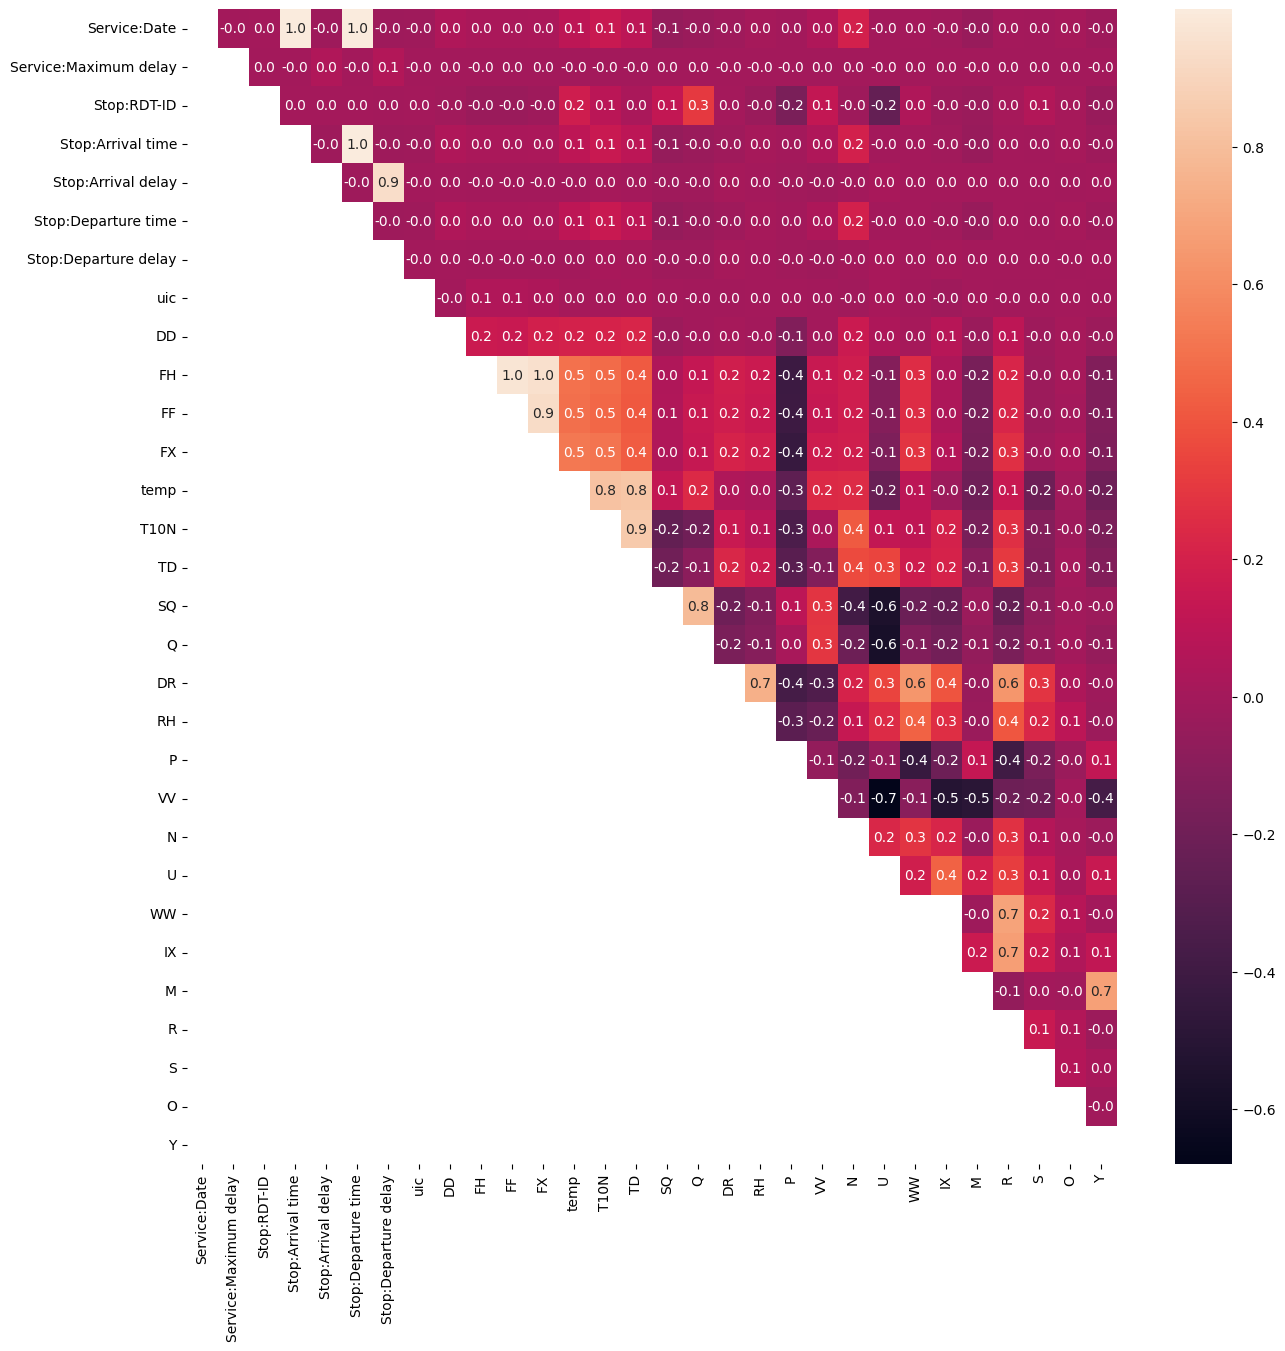

In [45]:
plt.subplots(figsize=(15, 15))
corr = combined_df.select_dtypes(include=['int32', 'int64', 'float64']).corr()
mask = np.tril(corr)
sns.heatmap(corr, mask=mask, cbar=True, annot=True, fmt=".1f")

Uit de correlatieplot is al redelijk wat zichtbaar. Maar om het duidelijker te maken, ga ik ze allemaal met elkaar vergelijken in plots.

Hieronder creëer ik de plots om dit goed te laten zien.

<Figure size 4000x4000 with 0 Axes>

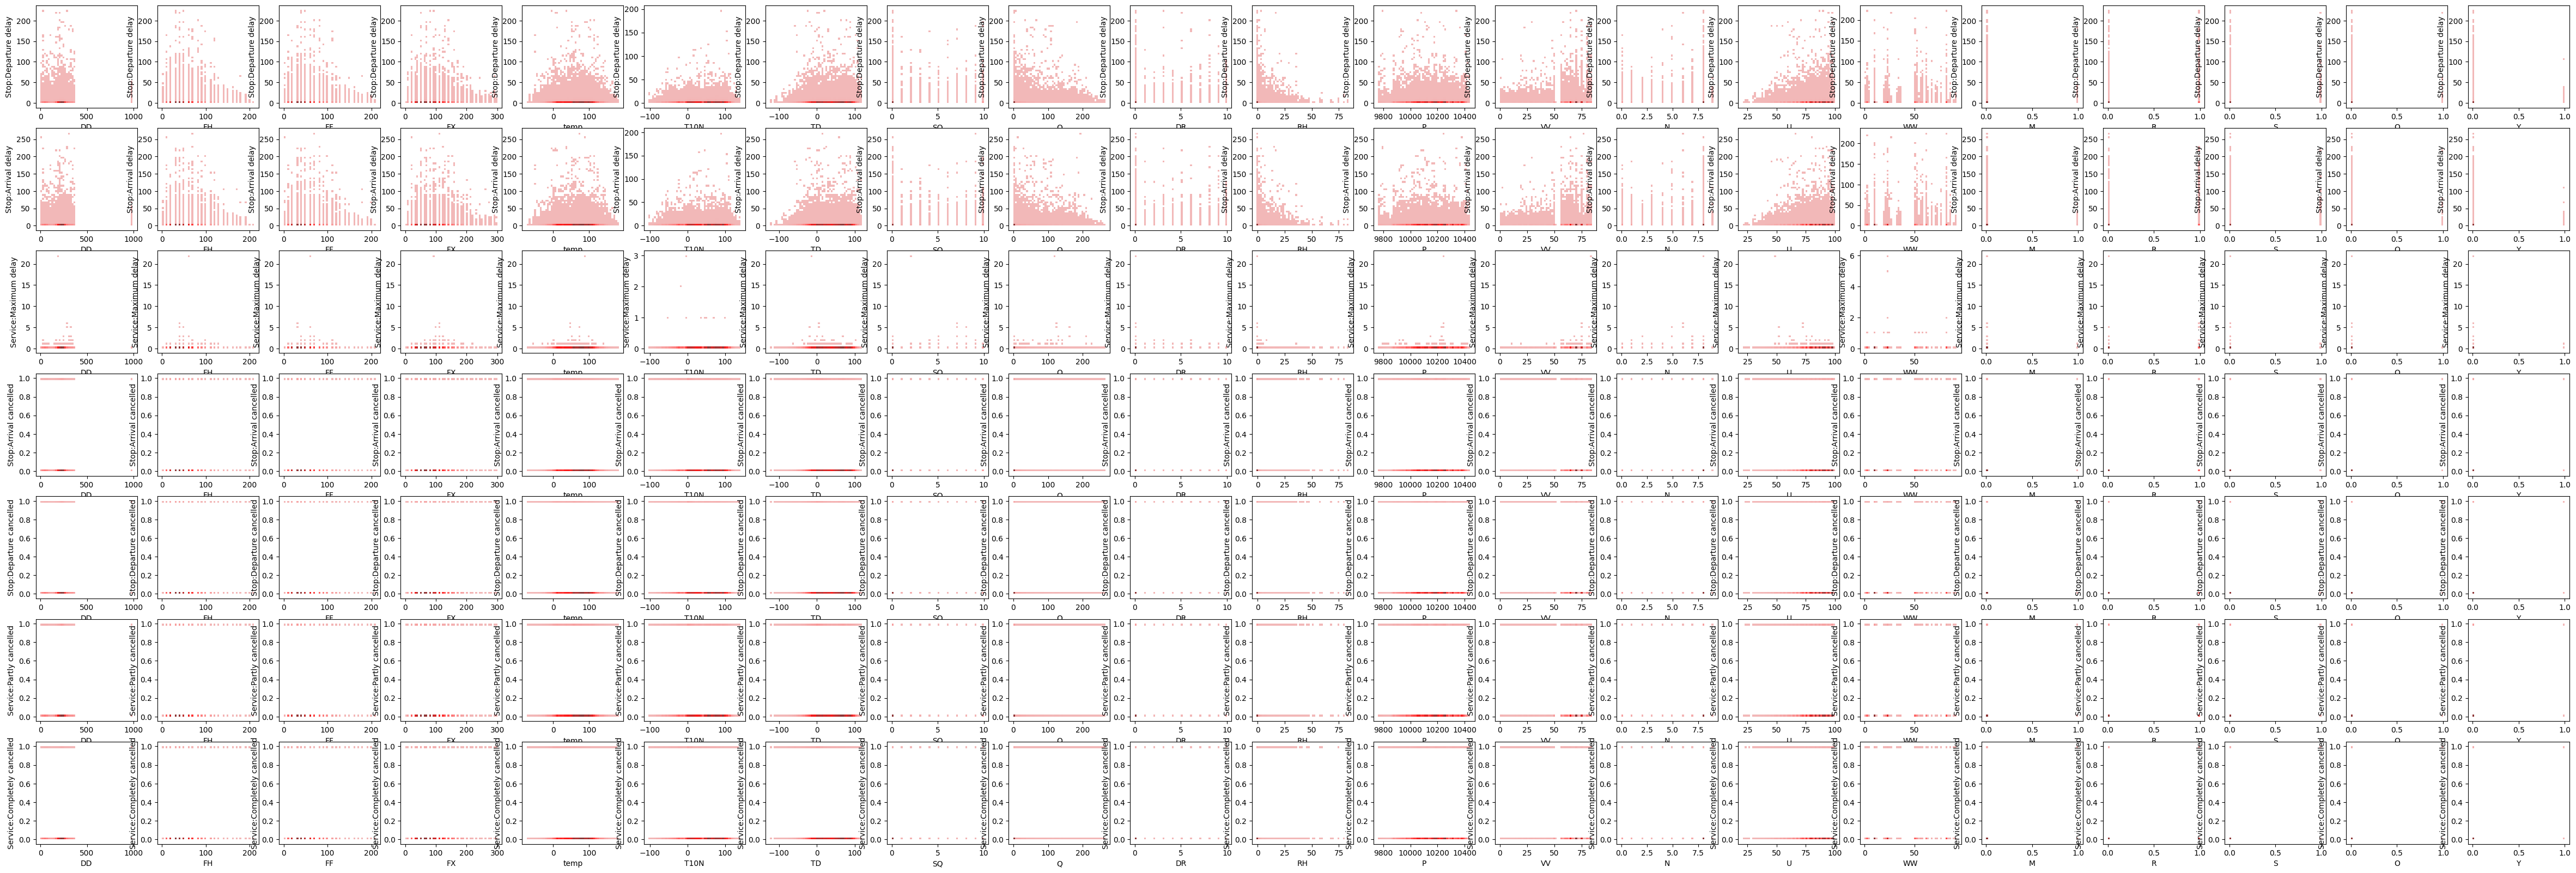

In [46]:
plt.figure(figsize=(40,40))

# sns.pairplot(combined_df.sample(frac=0.3)[['Service:Type','Stop:Arrival time', 'Stop:Departure time', 'Stop:Departure delay', 'Stop:Arrival delay', 'temp', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'IX', 'M', 'R', 'S', 'O', 'Y']], hue='Service:Type', corner= True, palette='rainbow')
input = combined_df[combined_df['country'] == 'NL']

Yfeatures = ['Stop:Departure delay', 'Stop:Arrival delay', 'Service:Maximum delay', 'Stop:Arrival cancelled', 'Stop:Departure cancelled', 'Service:Partly cancelled', 'Service:Completely cancelled'] # combined_df.columns
Xfeatures = ['DD' ,'FH' ,'FF' ,'FX' ,'temp' ,'T10N' ,'TD' ,'SQ' ,'Q' ,'DR' ,'RH' ,'P' ,'VV' ,'N' ,'U' ,'WW' ,'M' ,'R' ,'S' ,'O' ,'Y'] # combined_df.columns

pcount=1

plt.figure(figsize=(60, 20))
for Y in Yfeatures:
    for X in Xfeatures:
        plot = plt.subplot(Yfeatures.__len__(), Xfeatures.__len__(), pcount)
        sns.histplot(legend=True, color=[1,0,0], data=input, x=X, y=Y, bins=50)
        pcount +=1

plt.savefig('Combimed_Weather_Train_Pairplot.png')

Hierboven toon ik de correlaties op een geplotte manier. \
Het lijkt er echter op dat ik nog wat verder moet zoeken om te bepalen of er daadwerkelijk een manier is om dit te voorspellen. \
Op dit moment lijkt het erop dat ik weinig heb om mee te werken.


### 📃🪓 Splitting naar train/test

het is nu tijd om mijn data te splitten tussen training data en test data. \
Dit doe ik voor de testen en trainen van de machine learing modellen. \
Hier gebruik ik train_test_split van sklearn voor, dit is mij aangeleerd in eerdere opdrachten. 

In [51]:
from sklearn.model_selection import train_test_split

X = Smaller_combined_df.drop(columns=['Stop:Arrival delay', 'Service:Maximum delay'])
y = Smaller_combined_df[['Stop:Arrival delay']]

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=21 )
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")
display(X_train.dtypes)
display(X_train.isna().sum())
display(X_train.info())

There are in total 1253871 observations, of which 940403 are now in the train set, and 313468 in the test set.


Service:Date                    float64
Service:Type                      int32
Service:Completely cancelled       bool
Service:Partly cancelled           bool
Stop:RDT-ID                     float64
Stop:Station name                 int32
Stop:Arrival time               float64
Stop:Arrival cancelled             bool
Stop:Departure time             float64
uic                             float64
country                           int32
type                              int32
DD                              float64
FH                              float64
FF                              float64
FX                              float64
temp                            float64
T10N                            float64
TD                              float64
SQ                              float64
Q                               float64
DR                              float64
RH                              float64
P                               float64
VV                              float64


Service:Date                    0
Service:Type                    0
Service:Completely cancelled    0
Service:Partly cancelled        0
Stop:RDT-ID                     0
Stop:Station name               0
Stop:Arrival time               0
Stop:Arrival cancelled          0
Stop:Departure time             0
uic                             0
country                         0
type                            0
DD                              0
FH                              0
FF                              0
FX                              0
temp                            0
T10N                            0
TD                              0
SQ                              0
Q                               0
DR                              0
RH                              0
P                               0
VV                              0
N                               0
U                               0
WW                              0
IX                              0
M             

<class 'pandas.core.frame.DataFrame'>
Index: 940403 entries, 794871 to 3519301
Data columns (total 34 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Service:Date                  940403 non-null  float64
 1   Service:Type                  940403 non-null  int32  
 2   Service:Completely cancelled  940403 non-null  bool   
 3   Service:Partly cancelled      940403 non-null  bool   
 4   Stop:RDT-ID                   940403 non-null  float64
 5   Stop:Station name             940403 non-null  int32  
 6   Stop:Arrival time             940403 non-null  float64
 7   Stop:Arrival cancelled        940403 non-null  bool   
 8   Stop:Departure time           940403 non-null  float64
 9   uic                           940403 non-null  float64
 10  country                       940403 non-null  int32  
 11  type                          940403 non-null  int32  
 12  DD                            940403 non-nu

None

het ziet er naar uit dat de data hierboven goed is gesplit. \
Er is alleen wijnig in te zien waar een draad an te knowpen is. \
Maar nog steeds zal ik kijken wat er in de sets zit hieronder.

In [48]:
display(X_train.tail(5))
display(y_train.tail(5))

Service:Date  Service:Type  Service:Completely cancelled  \
3526960      0.000000             3                         False   
1239497      1.000000             9                         False   
164381       0.666667             9                         False   
4012454      0.666667             3                         False   
564179       0.833333             9                         False   

         Service:Partly cancelled  Stop:RDT-ID  Stop:Station name  \
3526960                     False     0.841239                446   
1239497                     False     0.754576                135   
164381                      False     0.885239                 20   
4012454                     False     0.431312                510   
564179                      False     0.897767                 32   

         Stop:Arrival time  Stop:Arrival cancelled  Stop:Departure time  \
3526960           0.000000                   False            -1.000000   
1239497           1.000000                   False             1.000000   
164381            0.666667                   False             0.666667   
4012454           0.666667                   False             0.666667   
564179            0.833333                   False             0.833333   

              uic  ...        VV         N         U        WW   IX    M    R  \
3526960  0.756620  ...  0.285714  0.888889  0.936709  0.565217  1.0  0.0  1.0   
1239497  0.756382  ... -1.000000 -1.000000  0.708861 -1.000000  0.5 -1.0 -1.0   
164381   0.756338  ...  0.952381  0.888889  0.569620  0.250000  1.0  0.0  1.0   
4012454  0.756680  ...  0.928571  0.888889  0.607595 -1.000000  0.0  0.0  0.0   
564179   0.756313  ...  0.833333  0.888889  0.772152  0.250000  1.0  0.0  1.0   

           S    O    Y  
3526960  0.0  0.0  0.0  
1239497 -1.0 -1.0 -1.0  
164381   0.0  0.0  0.0  
4012454  0.0  0.0  0.0  
564179   0.0  0.0  0.0  

[5 rows x 34 columns]

Stop:Arrival delay
3526960            0.000000
1239497            0.000000
164381             0.008929
4012454            0.000000
564179             0.000000

In [49]:
display(X_test.head(5))
display(y_test.head(5))

Service:Date  Service:Type  Service:Completely cancelled  \
1319171      1.000000            10                         False   
1794098      0.166667             3                         False   
2053586      0.500000             3                         False   
2878968      0.333333             9                         False   
1005833      1.000000            10                         False   

         Service:Partly cancelled  Stop:RDT-ID  Stop:Station name  \
1319171                     False     0.297529                 81   
1794098                     False     0.246390                126   
2053586                     False     0.043974                208   
2878968                     False     0.946618                358   
1005833                     False     0.753972                120   

         Stop:Arrival time  Stop:Arrival cancelled  Stop:Departure time  \
1319171           1.000000                   False             1.000000   
1794098           0.166667                   False             0.166667   
2053586           0.500000                   False             0.500000   
2878968           0.333333                   False             0.333333   
1005833           1.000000                   False             1.000000   

              uic  ...        VV         N         U    WW   IX    M    R  \
1319171  0.549328  ... -1.000000 -1.000000  0.721519 -1.00  0.5 -1.0 -1.0   
1794098  0.756434  ...  0.726190  0.888889  0.810127 -1.00  0.0  0.0  0.0   
2053586  0.756437  ... -1.000000 -1.000000 -1.000000 -1.00  0.5 -1.0 -1.0   
2878968  0.756548  ...  0.952381  0.777778  0.594937 -1.00  0.0  0.0  0.0   
1005833  0.756373  ...  0.738095  0.888889  0.911392  0.25  1.0  0.0  1.0   

           S    O    Y  
1319171 -1.0 -1.0 -1.0  
1794098  0.0  0.0  0.0  
2053586 -1.0 -1.0 -1.0  
2878968  0.0  0.0  0.0  
1005833  0.0  0.0  0.0  

[5 rows x 34 columns]

Stop:Arrival delay
1319171            0.000000
1794098            0.000000
2053586            0.000000
2878968            0.004464
1005833            0.000000

Het ziet er uit dat het goed is gesplit en dat ik vereder kan naar het maken van een eerste poging in Machine learining.

## 🧬 Modelling

### Decision Tree
Hieronder ga ik beginnen met een decisiontreeregressor van sklearn, dit is om te zien wat er gebeurt. 

mean squared err: 0.00015172037582403077
mean absolute err: 0.004999627870634173
mean squared log err: 0.00012859279405038072
max err: 0.9426387461459403
R squared: 0.035583038496755925


Text(0, 0.5, 'eigenlijke variable')

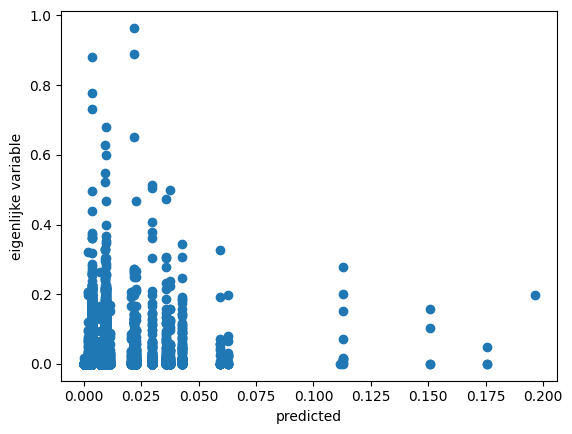

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,max_error,mean_squared_error,mean_squared_log_error,r2_score

tree = DecisionTreeRegressor(random_state=25, max_depth=5)

tree.fit(X_train, y_train)
tree.score(X_test, y_test)

pred = tree.predict(X_test)

msq = mean_squared_error(y_test,pred)
print("mean squared err:", msq)
mab = mean_absolute_error(y_test,pred)
print("mean absolute err:", mab)
msql = mean_squared_log_error(y_test,pred)
print("mean squared log err:", msql)
mx = max_error(y_test,pred)
print("max err:", mx)
Rsq = r2_score(y_test,pred)
print("R squared:", Rsq)

plt.scatter(pred, y_test)
plt.xlabel('predicted')
plt.ylabel('eigenlijke variable')

Het ziet ernaaruit dat hierboven er geen goede verbinding is om te voorspellen hoelang een vertraging is te bepalen, Want de test gaat er vanuit dat er niet zo veel vertraging is. \
zelfs all is er erge weeromstandigheden gemeld. 

hieronder laat ik zien waarom ik hyper parameters gebruik die ik gebruik hierboven.

In [20]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':list(range(5, 21)), 'random_state':list(range(20, 30))}

clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=10)
clf.fit(X_train, y_train)

df = pd.DataFrame(clf.cv_results_)
df.sort_values(by='rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9         1.383550      0.052501         0.032910        0.004670   
8         1.360434      0.022852         0.022548        0.003704   
7         1.319590      0.022095         0.030718        0.004214   
2         1.394482      0.025924         0.023387        0.004725   
5         1.320968      0.017483         0.029929        0.004009   
..             ...           ...              ...             ...   
150       4.040698      0.030783         0.027346        0.003383   
151       4.084840      0.032983         0.027395        0.001086   
159       3.915019      0.037795         0.021045        0.001988   
154       4.021103      0.018816         0.026219        0.003296   
157       4.023842      0.025901         0.027158        0.004099   

    param_max_depth param_random_state                                 params  \
9                 5                 29   {'max_depth': 5, 'random_state': 29}   
8                 5                 28   {'max_depth': 5, 'random_state': 28}   
7                 5                 27   {'max_depth': 5, 'random_state': 27}   
2                 5                 22   {'max_depth': 5, 'random_state': 22}   
5                 5                 25   {'max_depth': 5, 'random_state': 25}   
..              ...                ...                                    ...   
150              20                 20  {'max_depth': 20, 'random_state': 20}   
151              20                 21  {'max_depth': 20, 'random_state': 21}   
159              20                 29  {'max_depth': 20, 'random_state': 29}   
154              20                 24  {'max_depth': 20, 'random_state': 24}   
157              20                 27  {'max_depth': 20, 'random_state': 27}   

     split0_test_score  split1_test_score  split2_test_score  \
9             0.032087           0.036419           0.076407   
8             0.032087           0.036419           0.076407   
7             0.032087           0.036419           0.076407   
2             0.032087           0.036419           0.076407   
5             0.032087           0.036419           0.076407   
..                 ...                ...                ...   
150          -0.238856          -0.407118          -0.488603   
151          -0.280658          -0.540218          -0.298487   
159          -0.258677          -0.435636          -0.467134   
154          -0.291595          -0.479860          -0.445227   
157          -0.238492          -0.522900          -0.439356   

     split3_test_score  split4_test_score  mean_test_score  std_test_score  \
9             0.040098           0.019564         0.040915        0.019049   
8             0.040098           0.019564         0.040915        0.019049   
7             0.040098           0.019564         0.040915        0.019049   
2             0.040098           0.019564         0.040915        0.019049   
5             0.040098           0.019564         0.040915        0.019049   
..                 ...                ...              ...             ...   
150          -0.336659          -0.527773        -0.399802        0.104122   
151          -0.316655          -0.569125        -0.401028        0.126296   
159          -0.315934          -0.599047        -0.415285        0.119388   
154          -0.345751          -0.520413        -0.416569        0.085140   
157          -0.395254          -0.523385        -0.423878        0.105008   

     rank_test_score  
9                  1  
8                  1  
7                  3  
2                  4  
5                  4  
..               ...  
150              156  
151              157  
159              158  
154              159  
157              160  

[160 rows x 15 columns]

hieronder zal ik de decisionTree weergeven zodat het zichtbaar is wat het doet of meer gezien wat het waarschijnlijk doet. 

In [18]:
from sklearn.tree import plot_tree
plt.figure(figsize=(180,100))
plot_tree(tree, fontsize=8, feature_names=X.columns)

[Text(0.5823170731707317, 0.9166666666666666, 'Service:Type <= 13.5\nsquared_error = 0.0\nsamples = 321632\nvalue = 0.004'),
 Text(0.3048780487804878, 0.75, 'Service:Type <= 3.5\nsquared_error = 0.0\nsamples = 320799\nvalue = 0.004'),
 Text(0.13414634146341464, 0.5833333333333334, 'Stop:Station name <= 26.5\nsquared_error = 0.005\nsamples = 1019\nvalue = 0.026'),
 Text(0.04878048780487805, 0.4166666666666667, 'DD <= 0.03\nsquared_error = 0.016\nsamples = 99\nvalue = 0.073'),
 Text(0.024390243902439025, 0.25, 'squared_error = 0.0\nsamples = 1\nvalue = 0.519'),
 Text(0.07317073170731707, 0.25, 'DD <= 0.217\nsquared_error = 0.015\nsamples = 98\nvalue = 0.069'),
 Text(0.04878048780487805, 0.08333333333333333, 'squared_error = 0.024\nsamples = 48\nvalue = 0.11'),
 Text(0.0975609756097561, 0.08333333333333333, 'squared_error = 0.003\nsamples = 50\nvalue = 0.029'),
 Text(0.21951219512195122, 0.4166666666666667, 'Service:Maximum delay <= 0.1\nsquared_error = 0.003\nsamples = 920\nvalue = 0.021

hieronder laat ik de shaply van mij decision tree zien met behulp van de shap library. dit doe ik om te kijken wat er gebruikt word.

C:\Users\super\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


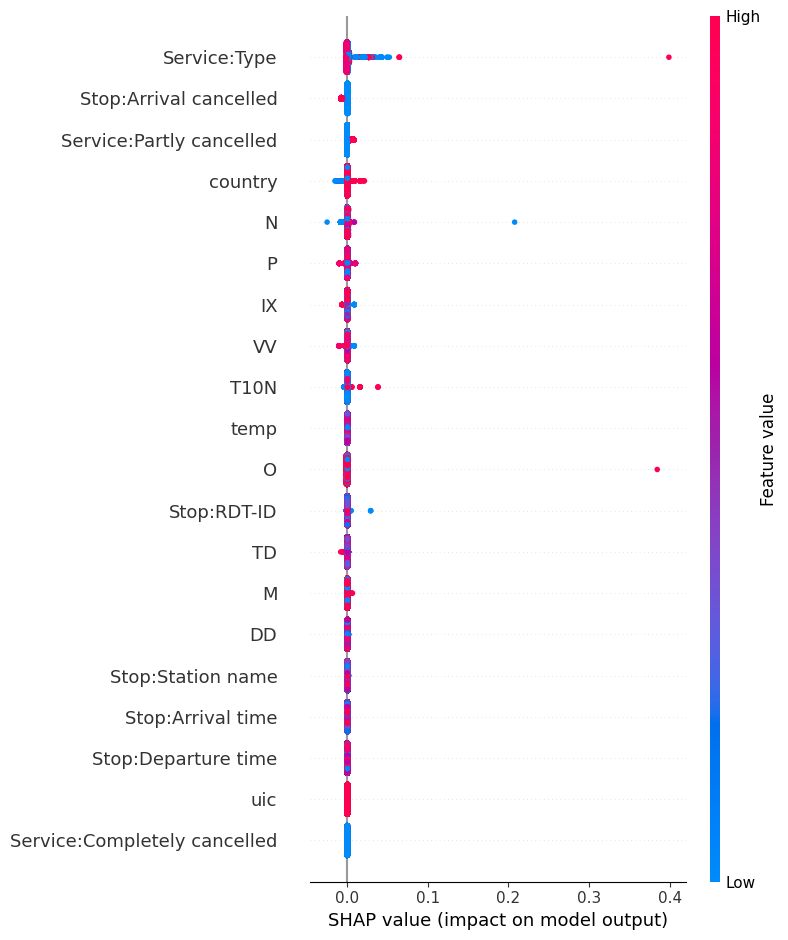

In [26]:
import shap

explainer = shap.Explainer(tree)
shap_values = explainer.shap_values(X_test)
# plt.figure(figsize=(18000,10000))

# shap.bar_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test)

Hieronder ga ik kijken naar een verzie van gridsearch om te kijken welke hyperparameterers goed zijn voor de modelen die ik later ga gebruiken om een beteren accarucy eruit krijgen.

Hieronder doe ik de Random forest regressor met behulp van de Scikit-learn library hun BayesSearchCV. \
het zou met deze sneler zijn om je hyperparameters te vinden volgens een andere student.

Als eerst ga ik mijn RandomForestRegressor doen.

In [108]:
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor

searchSpaces = { 
    'max_depth':list(range(5, 21)),
    'n_estimators':list(range(5, 16)),
    'random_state':list(range(15, 26)),
    }

opt = BayesSearchCV(RandomForestRegressor(), search_spaces=searchSpaces, n_jobs=-1, n_points=24)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.035911527237130335
test score: -0.42842673041392776
best params: OrderedDict([('max_depth', 8), ('n_estimators', 15), ('random_state', 24)])


C:\Users\super\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Nu ga ik mijn Lasso doen.

In [45]:
from skopt import BayesSearchCV
from sklearn.linear_model import Lasso

searchSpaces = { 
    'alpha':np.arange(0.2, 5.0, 0.2),
    'max_iter':np.arange(100, 1500, 100),
    'random_state':list(range(15, 26)),
    }

opt = BayesSearchCV(Lasso(), search_spaces=searchSpaces, n_jobs=-1, n_points=24)

opt.fit(X_train, y_train.squeeze())

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test.squeeze()))
print("best params: %s" % str(opt.best_params_))

val. score: -0.00035203268165866496
test score: 0.00029357364734106106
best params: OrderedDict([('alpha', 0.2), ('max_iter', 900), ('random_state', 20)])


Nu ga ik mijn BaggingRegressor doen.

In [11]:
from skopt import BayesSearchCV
from sklearn.ensemble import BaggingRegressor

searchSpaces = { 
    'n_estimators':np.arange(1, 20, 1),
    'max_samples':np.arange(0.01, 1, 0.01),
    'random_state':list(range(15, 26)),
    }

opt = BayesSearchCV(BaggingRegressor(), search_spaces=searchSpaces, n_jobs=-1, n_points=24)

opt.fit(X_train, y_train.squeeze())

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test.squeeze()))
print("best params: %s" % str(opt.best_params_))

val. score: 0.035199834231076865
test score: 0.07224559784689166
best params: OrderedDict([('max_samples', 0.15000000000000002), ('n_estimators', 19), ('random_state', 23)])


Nu ga ik mijn BaggingRegressor doen.

In [35]:
from skopt import BayesSearchCV
from sklearn.svm import LinearSVR

searchSpaces = { 
    'C':np.arange(0.1, 5, 0.1),
    'max_iter':np.arange(100, 1500, 100),
    'random_state':list(range(15, 26)),
    }

opt = BayesSearchCV(LinearSVR(), search_spaces=searchSpaces, n_jobs=-1, n_points=24)

opt.fit(X_train, y_train.squeeze())

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test.squeeze()))
print("best params: %s" % str(opt.best_params_))

val. score: -0.08166188625481788
test score: -0.13131061708956926
best params: OrderedDict([('C', 3.9000000000000004), ('max_iter', 500), ('random_state', 20)])


C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Anne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Nu ga ik mijn MLPRegressor doen.

In [142]:
from skopt import BayesSearchCV
from sklearn.neural_network import MLPRegressor

searchSpaces = { 
    "random_state":np.arange(20, 25, 1),
    "solver":['sgd', 'adam'],
    "alpha": np.arange(0.01, 1, 0.01),
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "max_iter": np.arange(100, 300, 20),
}

opt = BayesSearchCV(MLPRegressor(), search_spaces=searchSpaces, n_jobs=-1, n_points=24)

opt.fit(X_train, y_train.squeeze())

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

ValueError: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.

Nadat we hierboven alles hebben bekeken om er zeker van te zijn dat we de juiste hyperparameters hebben gekozen met de hulp van gridsearch \
kunnen we beginnen met het maken van een goed wekend staking regressie model die gebruik maakt van de hiervoor geteste modellen. \
Een staking regressie gaat proberen te voorspellen wat de tijd in minuten is met de hulp van meerdere modellen. \
Dat er meerdere modellen worden gebruikt is belangrijk omdat het dan fouten eruit zal halen. \
Dat in en op zichzelf zorgt ervoor dat het antwoord accurater voorspeld kan worden. \
Ik gebruik hier de StackingRegressor van sklearn omdat het degene is waar ik de meeste ervaring in heb. \
Voor de modellen die ik heb gekozen moesten Regressie modellen hebben. Dit is omdat de stackingRegressor van die alleen verwacht in zijn lijst met modellen.  

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet


estimators = [ 
    ('mlp', MLPRegressor(alpha=0.4, learning_rate='adaptive' , max_iter=240, random_state=22, solver='adam')),
    ('brr', BaggingRegressor(max_samples=0.78, n_estimators=19, random_state=16)),
    ('las', Lasso(alpha=0.2, max_iter=1100, random_state=17)),
    ('rfr', RandomForestRegressor(n_estimators=15, random_state=22, max_depth=6)),
    ('ridge', RidgeCV()),
]

reg = StackingRegressor(estimators=estimators, final_estimator=ElasticNet())

Result = reg.fit(X_train, y_train.squeeze())


Hieronder laat ik de scores zien van de hierboven getrainde stacking model.

In [28]:
print(f"scoren: {reg.score(X_test, y_test.squeeze())}")

scoren: -1.1500525039620513e-05


Na de gegevens van hieboven te hebben bekeken en de nummers die ik terug krijg tot me in heb genomen. \
Kan ik zeggen dat het weer niet veel te maken heeft met de hoeveelheid vertraging een trein oplopt.

# Conclussie

Na het bekijken van de data die ik heb geregen en de statistieken die ik terug krijg van de testen die ik heb gedaan is het onwaarschijnlijk dat ik kan bepallen hoeveel minuten langer je zall moeten wachten op je trein. \
Dit is een teleurstelling met wat ik zelf had verwacht.

## in en out of controlle controllen

### A/B testen
hieronder controlleer ik of de service:Type's vergenoeg uit elkaar liggen om te kijken of er iets is om mee te werken. \
In de eerste code block hieronder check ik of de sprinters en de intercity's ver genoeg uit elkaar zitten om infromatie eruit te halen.

In [37]:
from scipy import stats

group_a = combined_df[combined_df['Service:Type'] == 'sprinter']['Stop:Arrival delay']
group_b = combined_df[combined_df['Service:Type'] == 'intercity']['Stop:Arrival delay']

t_stat, p_val = stats.ttest_ind(group_b, group_a)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

if p_val < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")


T-statistic: 90.92665650883148
P-value: 0.0
There is a significant difference between the two groups.


In de tweede code blok hieronder kijk ik naar all inbegrepen Service types tegen over de mean van all de Stop:Arrival delay. \
Dit doe ik door alle unieke service types op te vragen en dan erdoor heen lopen, vergelijken met de mean en dan kijken of er een probleem oploopt.

In [53]:
import pandas as pd
from scipy import stats

service_types = combined_df['Service:Type'].unique()

results = []

for service_type in service_types:
    group = combined_df[combined_df['Service:Type'] == service_type]['Stop:Arrival delay']
    t_stat, p_val = stats.ttest_1samp(group, combined_df['Stop:Arrival delay'].mean())
    
    results.append({
        'Service:Type': service_type,
        'T-statistic': t_stat,
        'P-value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

print(pd.DataFrame(results))

         Service:Type  T-statistic        P-value Significant
0            sprinter   -80.526057   0.000000e+00         Yes
1         extra trein    12.839285   7.112321e-35         Yes
2           intercity    50.374903   0.000000e+00         Yes
3              thalys    36.740517  2.111804e-279         Yes
4            nightjet    22.536041  1.980897e-108         Yes
5           stoptrein   -77.915583   0.000000e+00         Yes
6   ice international    33.593550  2.307952e-234         Yes
7           sneltrein    18.842498   4.387846e-79         Yes
8          nachttrein     5.791327   1.848929e-08         Yes
9    intercity direct    71.358031   0.000000e+00         Yes
10           eurostar    13.592323   1.910054e-40         Yes
11     speciale trein   -16.612243   1.606630e-56         Yes


Het ziet ernaar uit dat de meeste service types goed gebruikt kan worden. \
Maar der zitten er een paar tussen die niet goed gebruikt kan worden en meschien weg zullen moeten gelaten worden.

Hieronder laat ik zien hoe de data eruit zag voordat ik service types verwijderd out de dataset

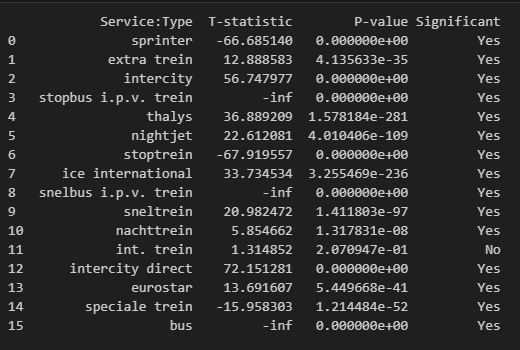

maar in conclusie van de A/B testen het ziet er naar uit dat met all de aanpassingen de kans op het berekenen van de tijd van vertraging is niet mogelijk of slecht mogelijk.